# MNAV - Heterogeneous GNN

Dataset: MNAV

Modelo: GNN con grafo heterogéneo

## Importar Datos

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from itertools import combinations
from copy import deepcopy
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
import torch
import networkx as nx
from sklearn.preprocessing import OrdinalEncoder

from torch_geometric.data import Data, HeteroData
from torch_geometric.nn.conv.dna_conv import Linear
from torch_geometric.utils import to_networkx, is_undirected, to_undirected

import torch.nn.functional as F
from torch_geometric.nn import GCNConv, ChebConv, SAGEConv, TAGConv, GraphConv, to_hetero, GATConv, Linear, BatchNorm, HeteroConv, HANConv
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


/home/fede/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


El dataset se encuentra disponible en https://github.com/ffedee7/posifi_mnav/tree/master/data_analysis. El dataset disponible está anonimizado pero se puede deshacer con el código de ese repositorio.

In [2]:
dataset = 'datos2.csv'
df = pd.read_csv(dataset)

In [3]:
print(df.shape)
df.describe()

(10469, 189)


,wifi-c0:7b:bc:36:af:80,wifi-1c:1d:86:b8:ac:80,wifi-f8:4f:57:ab:ce:20,wifi-dc:a5:f4:43:72:e0,wifi-c0:7b:bc:36:af:40,wifi-c0:7b:bc:36:9e:10,wifi-1c:1d:86:d0:ef:00,wifi-dc:a5:f4:43:79:20,wifi-ec:08:6b:ec:36:12,wifi-1c:1d:86:9f:99:20,...,wifi-84:74:2a:01:41:27,wifi-90:f6:52:f8:d1:dc,wifi-6a:fb:7e:26:34:bc,wifi-34:fa:40:08:f1:c8,wifi-54:22:f8:90:0b:b6,wifi-b0:4e:26:78:8d:e2,wifi-d4:6e:0e:3a:9f:fa,wifi-58:6d:8f:d7:68:d6,wifi-ac:84:c6:56:17:0e,wifi-00:87:01:6f:b6:ae
count,8278.000000,8313.000000,4127.000000,9365.000000,10289.000000,9230.000000,2001.000000,9381.000000,4711.000000,10024.000000,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
mean,-83.642426,-74.133406,-81.040950,-77.477950,-75.078725,-82.051896,-84.896052,-74.916214,-77.211208,-78.225359,...,-97.0,-95.0,-90.0,-84.0,-89.0,-88.0,-93.0,-90.0,-90.0,-89.0
std,6.342463,11.268483,11.139033,9.777461,8.545359,8.589948,10.273665,9.073052,12.254007,8.259183,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,-96.000000,-96.000000,-96.000000,-98.000000,-95.000000,-96.000000,-99.000000,-94.000000,-96.000000,-95.000000,...,-97.0,-95.0,-90.0,-84.0,-89.0,-88.0,-93.0,-90.0,-90.0,-89.0
25%,-89.000000,-83.000000,-91.000000,-85.000000,-81.000000,-89.000000,-94.000000,-81.000000,-88.000000,-85.000000,...,-97.0,-95.0,-90.0,-84.0,-89.0,-88.0,-93.0,-90.0,-90.0,-89.0
50%,-84.000000,-75.000000,-84.000000,-78.000000,-75.000000,-83.000000,-88.000000,-76.000000,-81.000000,-78.000000,...,-97.0,-95.0,-90.0,-84.0,-89.0,-88.0,-93.0,-90.0,-90.0,-89.0
75%,-79.000000,-66.000000,-72.000000,-71.000000,-69.000000,-77.000000,-79.000000,-70.000000,-67.000000,-73.000000,...,-97.0,-95.0,-90.0,-84.0,-89.0,-88.0,-93.0,-90.0,-90.0,-89.0
max,-57.000000,-42.000000,-49.000000,-42.000000,-44.000000,-41.000000,-50.000000,-38.000000,-45.000000,-42.000000,...,-97.0,-95.0,-90.0,-84.0,-89.0,-88.0,-93.0,-90.0,-90.0,-89.0


In [4]:
df.head()

,location,wifi-c0:7b:bc:36:af:80,wifi-1c:1d:86:b8:ac:80,wifi-f8:4f:57:ab:ce:20,wifi-dc:a5:f4:43:72:e0,wifi-c0:7b:bc:36:af:40,wifi-c0:7b:bc:36:9e:10,wifi-1c:1d:86:d0:ef:00,wifi-dc:a5:f4:43:79:20,wifi-ec:08:6b:ec:36:12,...,wifi-84:74:2a:01:41:27,wifi-90:f6:52:f8:d1:dc,wifi-6a:fb:7e:26:34:bc,wifi-34:fa:40:08:f1:c8,wifi-54:22:f8:90:0b:b6,wifi-b0:4e:26:78:8d:e2,wifi-d4:6e:0e:3a:9f:fa,wifi-58:6d:8f:d7:68:d6,wifi-ac:84:c6:56:17:0e,wifi-00:87:01:6f:b6:ae
0,location_7,-84.0,-71.0,-92.0,-68.0,-77.0,-79.0,-90.0,-74.0,-92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,location_3,-84.0,-72.0,NaN,-75.0,-79.0,-85.0,NaN,-87.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,location_8,-91.0,-82.0,NaN,-78.0,-80.0,-93.0,NaN,-79.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,location_10,NaN,-95.0,NaN,-91.0,-85.0,-93.0,NaN,-89.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,location_3,-85.0,-66.0,NaN,-80.0,-79.0,-86.0,NaN,-88.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preprocesamiento

Se definen los APs que se quieren usar tanto para la construcción del grafo como para el modelo.

En este caso usamos solamente los APs que se encuentran dentro del MNAV, es decir que descartamos los APs que aparecen en las medidas pero que no son los que se instalaron.

In [5]:
APs_MAC_2_4 = ['wifi-dc:a5:f4:43:85:c0',
'wifi-dc:a5:f4:43:27:e0',
'wifi-f8:4f:57:ab:da:00',
'wifi-5c:a4:8a:4c:05:c0',
'wifi-1c:1d:86:ce:ef:b0',
'wifi-dc:a5:f4:43:79:20',
'wifi-c0:7b:bc:36:9e:10',
'wifi-1c:1d:86:9f:99:20',
'wifi-c0:7b:bc:36:af:40',
'wifi-c0:7b:bc:36:af:80',
'wifi-1c:1d:86:b6:ac:80',
'wifi-dc:a5:f4:43:72:e0',
'wifi-f8:4f:57:ab:d8:60',
'wifi-dc:a5:f4:43:72:90',
'wifi-f8:4f:57:ab:ce:20']

APs_MAC_5 = ['wifi-dc:a5:f4:45:85:b0',
'wifi-dc:a5:f4:45:27:e0',
'wifi-f8:4f:57:ad:d9:60',
'wifi-5c:a4:8a:4e:05:30',
'wifi-1c:1d:86:d0:ef:00',
'wifi-dc:a5:f4:45:79:10',
'wifi-c0:7b:bc:38:9e:00',
'wifi-1c:1d:86:a1:99:00',
'wifi-c0:7b:bc:38:af:30',
'wifi-c0:7b:bc:38:af:70',
'wifi-1c:1d:86:b8:ac:80',
'wifi-dc:a5:f4:45:72:d0',
'wifi-f8:4f:57:ad:d7:c0',
'wifi-dc:a5:f4:45:72:80',
'wifi-f8:4f:57:ad:cd:80']

In [6]:
def preprocess_dataset(dataset_path, zone_to_remove=None, dataset_percentage=None):
    df = pd.read_csv(dataset_path)
    # paso los NaN a 0
    df = df.fillna(0) 

    # sumo 100 a los valores de RSSI y ahora 0 es el minimo
    df.iloc[:,1:] = 100 + df.iloc[:,1:] 
    values = df.iloc[:,1:]

    # las medidas originales en 0 las asumo como que estaban muy lejos
    # entonces las dejo en 0 que es el nuevo valor minimo
    values[values==100] = 0 
    df.iloc[:,1:] = values    
    
    # armo dos datsets: uno con las medidas solamente de la frecuencia
    # 2.4GHz y otro con las frecuencias 2.4GHz y 5GHz
    data_2_4 = df[['location'] + APs_MAC_2_4] # REVISAR PORQUE CREO QUE NO LO VUELVO A USAR
    data_2_4_5 = df[['location'] + APs_MAC_2_4 + APs_MAC_5]
    
    if dataset_percentage:
        data_2_4_5 = data_2_4_5.sample(frac=dataset_percentage)
    
    # paso las zonas por un ordinal encoder
    enc = OrdinalEncoder(dtype=int)
    y = enc.fit_transform(data_2_4_5['location'].values.reshape(-1,1))
    X = data_2_4_5.iloc[:,1:].values

    print(enc.categories_)

    # separo el dataset en train y test 80-20
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)    
    
#     if zone_to_remove:
#         X_train_modif = X_train[(y_train != zone_to_remove).reshape(-1)]
#         y_train_modif = y_train[(y_train != zone_to_remove).reshape(-1)]
#         y_train_modif[y_train_modif>zone_to_remove] = y_train_modif[y_train_modif>zone_to_remove] - 1
        
#         X_test_modif = X_test[(y_test != zone_to_remove).reshape(-1)]
#         y_test_modif = y_test[(y_test != zone_to_remove).reshape(-1)]
#         y_test_modif[y_test_modif>zone_to_remove] = y_test_modif[y_test_modif>zone_to_remove] - 1
        
#         print("X_train shape: ", X_train_modif.shape)
#         return X_train_modif, X_test_modif, y_train_modif, y_test_modif, len(APs_MAC_2_4), len(np.unique(y_train_modif)), enc
        
    print("X_train shape: ", X_train.shape)
    return X_train, X_test, y_train, y_test, len(APs_MAC_2_4), len(np.unique(y_train)), enc

## Grafo

En las siguientes celdas se describe un poco el dataset y se muestran las distribuciones de potencia por AP.

In [7]:
def ap_graph_creator(X_G, th=10, cols=None, prune_th=0):
    """
    Dado un dataset y un threshold se arma un grafo basado en las medidas de RRSI
    """
    columns = cols if cols else ['AP1', 'AP2', 'AP3', 'AP4', 'AP5', 'AP6', 'AP7', 'AP8', 'AP9', 'AP10', 'AP11', 'AP12', 'AP13', 'AP14', 'AP15']
    df_data_train = pd.DataFrame(X_G, columns=columns)
    df_G = pd.DataFrame(columns = ['from', 'to', 'weight'])

    for ap in columns:
        # para cada AP me quedo con las instancias donde el RSSI esta en el rango
        # (max-th) intentando estimar las instancias mas cercanas al AP
        max_val = df_data_train[ap].max()
        # print(f"Max: {max_val}")
        df_aux_i = df_data_train[df_data_train[ap]  > (max_val - th)]
        df_aux_i = df_aux_i.drop(ap, axis=1)
        # print(f"Counts: {df_aux_i.shape[0]}")
        # import ipdb; ipdb.set_trace()
        for k, v in df_aux_i.mean().items():
            # print(v)
            # armo las aristas con el promedio de RSSI que ven las instancias
            # filtradas al resto de los APs
            # weight = v
            # if df_G.loc[(df_G['from'] == k) & (df_G['to'] == ap)].weight.any():
            #     weight = np.mean([float(df_G.loc[(df_G['from'] == k) & (df_G['to'] == ap)].weight), weight])
            #     df_G.loc[(df_G['from'] == k) & (df_G['to'] == ap)] = k, ap, weight
            if v > prune_th:
                df_G = df_G.append({'from':ap, 'to': k, 'weight': v}, ignore_index=True)
        

    edge_index_first_row = []
    edge_index_second_row = []
    edge_attr = []
    for index, row in df_G.iterrows():
        edge_index_first_row.append(columns.index(row['from']))
        edge_index_second_row.append(columns.index(row['to']))
        edge_attr.append([float(row.weight)])

    edge_index = torch.tensor([edge_index_first_row, edge_index_second_row], dtype=torch.long)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)                           
    edge_index, edge_attr = to_undirected(edge_index, edge_attr, reduce="mean")

    return edge_index, edge_attr

In [8]:
def zone_ap_graph_creator(X_G, y, cols=None, prune_th=0, zone_to_remove=None):

    columns = cols if cols else ['AP1', 'AP2', 'AP3', 'AP4', 'AP5', 'AP6', 'AP7', 'AP8', 'AP9', 'AP10', 'AP11', 'AP12', 'AP13', 'AP14', 'AP15']
    df_data_train = pd.DataFrame(X_G, columns=columns)
    df_data_train['cls'] = y
    df_G = pd.DataFrame(columns = ['from', 'to', 'weight'])

    for zone in range(len(df_data_train['cls'].unique())): # np.sort(df_data_train['cls'].unique()):

        filtered_instances = df_data_train.loc[df_data_train['cls'] == zone]
        means = np.array(filtered_instances.mean())[:-1]

        for ap, mean in enumerate(means):
            if mean > prune_th:
                # if zone_to_remove != zone:
                if zone_to_remove == zone:
                    mean = 0
                df_G = df_G.append({'from':zone, 'to': ap, 'weight': mean}, ignore_index=True)

    edge_index_first_row = []
    edge_index_second_row = []
    edge_attr = []
    for index, row in df_G.iterrows():
        edge_index_first_row.append(row['from'])
        edge_index_second_row.append(row['to'])
        edge_attr.append([float(row.weight)])
    
    edge_index = torch.tensor([[int(i) for i in edge_index_first_row], [int(i) for i in edge_index_second_row]], dtype=torch.long)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)                           

    return edge_index, edge_attr

In [9]:
def build_dataset(X, y, graph, zone_to_remove=None):
    dataset = []
    # random = torch.randn(16,5)
    one_hot = torch.nn.functional.one_hot(torch.arange(0,16)).float()
    
    for i in range(len(y)):
        if y[i] != zone_to_remove:
            data = deepcopy(graph)
            data['aps'].x = torch.Tensor(X[i])

            # data['zones'].x = torch.ones(data['zones'].num_nodes,1)
            data['zones'].x = torch.zeros(data['zones'].num_nodes,1)
            # data['zones'].x = torch.randn(data['zones'].num_nodes,5)
            # data['zones'].x = one_hot
            # data['zones'].x -= data['zones'].x.mean()
            # data['zones'].x /= data['zones'].x.std()
            data['zones'].y = torch.Tensor(y[i])
            data['zones'].train_mask = torch.Tensor([True]*len(y))
            data['zones'].val_mask = torch.Tensor([True]*len(y))
            data['zones'].test_mask = torch.Tensor([True]*len(y))

            dataset.append(data)
    return dataset

In [10]:
def build_heterodata(ap_edge_index, ap_edge_attr, zone_ap_edge_index, zone_ap_edge_attr, classes=16):
    data = HeteroData()
    data['aps', 'ap_ap', 'aps'].edge_index = ap_edge_index
    ap_edge_attr = (ap_edge_attr - ap_edge_attr.mean())/ap_edge_attr.std()
    data['aps', 'ap_ap', 'aps'].edge_attr = ap_edge_attr
    data['aps'].num_nodes = 15

    data['zones', 'zone_ap', 'aps'].edge_index = zone_ap_edge_index
    zone_ap_edge_attr = (zone_ap_edge_attr - zone_ap_edge_attr.mean())/zone_ap_edge_attr.std()    
    data['zones', 'zone_ap', 'aps'].edge_attr = torch.nn.functional.normalize(zone_ap_edge_attr, dim=0)
    data['zones'].num_nodes = classes
    return data

## Modelo

In [11]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, hidden_layers):
        super().__init__()
        
        self.hidden_convs = torch.nn.ModuleList()
        for _ in range(hidden_layers):
            conv = HeteroConv({
                ('aps', 'ap_ap', 'aps'): GraphConv((-1, -1), hidden_channels),
                ('zones', 'zone_ap', 'aps'): GraphConv((-1, -1), hidden_channels),
                ('aps', 'rev_zone_ap', 'zones'): GraphConv((-1, -1), hidden_channels),
            }, aggr='mean')
            self.hidden_convs.append(conv)
        
        self.out_convs = torch.nn.ModuleList()
        conv = HeteroConv({
            ('aps', 'ap_ap', 'aps'): GraphConv((-1, -1), out_channels),
            ('zones', 'zone_ap', 'aps'): GraphConv((-1, -1), out_channels),
            ('aps', 'rev_zone_ap', 'zones'): GraphConv((-1, -1), out_channels),
        }, aggr='mean')
        self.out_convs.append(conv)        

        # self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        for conv in self.hidden_convs:
            x_dict = conv(x_dict, edge_index_dict, edge_attr_dict)
            x_dict = {key: x.relu() for key, x in x_dict.items()}
        for conv in self.out_convs:
            x_dict = conv(x_dict, edge_index_dict, edge_attr_dict)
           # x_dict = {key: x.relu() for key, x in x_dict.items()}

        # out = self.lin(x_dict['zones'])
        
        return x_dict

In [12]:
class HeteroGNN_simplified(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, hidden_layers):
        super().__init__()
        
        self.hidden_convs = torch.nn.ModuleList()
        for _ in range(hidden_layers):
            conv = HeteroConv({
                ('aps', 'ap_ap', 'aps'): GraphConv((-1, -1), hidden_channels),
                # ('zones', 'zone_ap', 'aps'): GraphConv((-1, -1), hidden_channels),
                # ('aps', 'rev_zone_ap', 'zones'): GraphConv((-1, -1), hidden_channels),
            }, aggr='sum')
            self.hidden_convs.append(conv)
        
        self.out_convs = torch.nn.ModuleList()
        conv = HeteroConv({
            ('aps', 'ap_ap', 'aps'): GraphConv((-1, -1), out_channels),
            ('zones', 'zone_ap', 'aps'): GraphConv((-1, -1), out_channels),
            ('aps', 'rev_zone_ap', 'zones'): GraphConv((-1, -1), out_channels),
        }, aggr='sum')
        self.out_convs.append(conv)        

        # self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        initial_zones_signal = x_dict["zones"]
        for conv in self.hidden_convs:
            x_dict = conv(x_dict, edge_index_dict, edge_attr_dict)
            x_dict = {key: x.relu() for key, x in x_dict.items()}
        x_dict["zones"] = initial_zones_signal
        for conv in self.out_convs:
            x_dict = conv(x_dict, edge_index_dict, edge_attr_dict)
           # x_dict = {key: x.relu() for key, x in x_dict.items()}

        # out = self.lin(x_dict['zones'])
        
        return x_dict

## Entrenamiento

### Armado dataset

In [13]:
# Split de los datos y armado del objeto Data con el grafo

X_train, X_test, y_train, y_test, num_aps, num_classes, enc_train = preprocess_dataset(dataset, dataset_percentage=0.3)
ap_edge_index, ap_edge_attr = ap_graph_creator(X_train[:,:15], th=20, prune_th=20) #el grafo lo armo solo con los datos de 2.4Ghz
zone_ap_edge_index, zone_ap_edge_attr = zone_ap_graph_creator(X_train[:,:15], y_train, prune_th=20) #el grafo lo armo solo con los datos de 2.4Ghz
data = build_heterodata(ap_edge_index, ap_edge_attr, zone_ap_edge_index, zone_ap_edge_attr)
T.ToUndirected()(data)

[array(['location_1', 'location_10', 'location_11', 'location_12',
       'location_13', 'location_14', 'location_15', 'location_16',
       'location_2', 'location_3', 'location_4', 'location_5',
       'location_6', 'location_7', 'location_8', 'location_9'],
      dtype=object)]
X_train shape:  (2512, 30)


HeteroData(
  aps={ num_nodes=15 },
  zones={ num_nodes=16 },
  (aps, ap_ap, aps)={
    edge_index=[2, 124],
    edge_attr=[124, 1]
  },
  (zones, zone_ap, aps)={
    edge_index=[2, 107],
    edge_attr=[107, 1]
  },
  (aps, rev_zone_ap, zones)={
    edge_index=[2, 107],
    edge_attr=[107, 1]
  }
)

In [14]:
print(ap_edge_index)

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,
          1,  2,  2,  2,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  5,
          5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,
          9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11,
         11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14],
        [ 1,  2,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  0,  2,  5,  6, 12, 13,
         14,  0,  1,  5, 12, 13, 14,  4,  7,  8,  3,  7,  8,  0,  1,  2,  6,  7,
          8,  9, 11, 12, 13, 14,  0,  1,  5,  7,  8,  9, 11, 12,  0,  3,  4,  5,
          6,  8,  9, 10, 11, 12,  0,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13,  0,
          5,  6,  7,  8, 10, 11, 12, 13,  0,  7,  8,  9, 11, 12, 13,  0,  5,  6,
          7,  8,  9, 10, 12, 13,  0

In [15]:
# Armado del dataset

x_training_data = np.reshape(X_train,(X_train.shape[0],15,2))
x_test_data = np.reshape(X_test,(X_test.shape[0],15,2))
y_training_data = y_train
y_test_data = y_test

#normalize (x-mean)/std
mean = x_training_data.mean(axis=0)
std = x_training_data.std(axis=0)

x_training_data = x_training_data - mean
x_training_data /= std
x_test_data = x_test_data - mean
x_test_data /= std

In [16]:
train_dataset = build_dataset(x_training_data, y_training_data, data)
test_dataset = build_dataset(x_test_data, y_test_data, data)

In [17]:
train_dataset[0]

HeteroData(
  aps={
    num_nodes=15,
    x=[15, 2]
  },
  zones={
    num_nodes=16,
    x=[16, 1],
    y=[1],
    train_mask=[2512],
    val_mask=[2512],
    test_mask=[2512]
  },
  (aps, ap_ap, aps)={
    edge_index=[2, 124],
    edge_attr=[124, 1]
  },
  (zones, zone_ap, aps)={
    edge_index=[2, 107],
    edge_attr=[107, 1]
  },
  (aps, rev_zone_ap, zones)={
    edge_index=[2, 107],
    edge_attr=[107, 1]
  }
)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [19]:
# device = torch.device('cuda:1')
# device

In [20]:
batch_size = 16
learning_rate = 0.01

### HeteroGNN

In [21]:
model = HeteroGNN(20, 1, 4).to(device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
loss = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
print_every = 5

In [22]:
# with torch.no_grad():  # Initialize lazy modules.
#     batch = train_dataset[0].to(device)
#     out = model(batch.x_dict, batch.edge_index_dict)

In [ ]:
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
best_test_accuracy = 0


m = torch.nn.Softmax(dim=1)

for epoch in range(250):
    # print(f"Epoch: {epoch+1}")
    
    # TRAIN
    model.train()
    train_accuracy_epoch = []
    train_loss_epoch = []
    for data in train_loader:
        
        data = data.to(device)
        out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
        out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)

        loss_result = loss(out_zones.cpu(), data["zones"].y.cpu().type(torch.long))
        loss_result.backward()
        train_loss_epoch.append(loss_result.detach().cpu())
        
        optimizer.step()
        optimizer.zero_grad()

        output = m(out_zones)
        train_accuracy_epoch.append(accuracy_score(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))

    # if scheduler.get_last_lr()[0] > 0.0005:
    if (epoch+1)%20 == 0:
        scheduler.step()

    train_accuracy.append(np.mean(train_accuracy_epoch))
    train_loss.append(np.mean(train_loss_epoch))
    
    
    
    # VALIDATION
    model.eval()
    test_accuracy_epoch = []
    test_loss_epoch = []
    for data in test_loader:
        
        data = data.to(device)
        out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
        # out_zones = torch.mean(out["zones"].cpu(),1)
        # out_zones = out_zones.reshape(out_zones.shape[0]//num_classes,num_classes)
        out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)

        # out_zones = out.cpu().reshape(out.cpu().shape[0]//num_classes,num_classes)
        
        loss_result = loss(out_zones.cpu(), data["zones"].y.cpu().type(torch.long))        
        test_loss_epoch.append(loss_result.detach().cpu())
        
        output = m(out_zones)
        test_accuracy_epoch.append(accuracy_score(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))

    test_accuracy.append(np.mean(test_accuracy_epoch))
    if test_accuracy[-1] > best_test_accuracy:
        best_test_accuracy = test_accuracy[-1]        
        torch.save(model.state_dict(), "MNAV_HeteroGNN_best_model.pth")
        
    test_loss.append(np.mean(test_loss_epoch))

    if (epoch+1)%print_every == 0:
        print(f"Epoch {epoch+1}, Train Loss {np.mean(train_loss_epoch)}, Val Loss {np.mean(test_loss_epoch)}")
    
print(f"Last LR: {scheduler.get_last_lr()}")
print(f"Best Accuracy: Train {np.max(train_accuracy)}, Val {np.max(test_accuracy)}")

plt.figure()
plt.plot(train_loss, label="Train loss")
plt.plot(test_loss, label="Validation loss")
plt.legend()

plt.figure()
plt.plot(train_accuracy, label="Train accuracy")
plt.plot(test_accuracy, label="Validation accuracy")
plt.legend()

plt.show()


In [23]:
m = torch.nn.Softmax(dim=1)
output = m(out_zones)
accuracy = accuracy_score(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1)))

print(accuracy)
print(classification_report(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))

NameError: name 'out_zones' is not defined

### HeteroGNNSimplified

In [24]:
model = HeteroGNN_simplified(20, 1, 4).to(device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
loss = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
print_every = 5

In [ ]:
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
best_test_accuracy = 0


m = torch.nn.Softmax(dim=1)

for epoch in range(250):
    # print(f"Epoch: {epoch+1}")
    
    # TRAIN
    model.train()
    train_accuracy_epoch = []
    train_loss_epoch = []
    for data in train_loader:
        
        data = data.to(device)
        out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
        out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)

        loss_result = loss(out_zones.cpu(), data["zones"].y.cpu().type(torch.long))
        loss_result.backward()
        train_loss_epoch.append(loss_result.detach().cpu())
        
        optimizer.step()
        optimizer.zero_grad()

        output = m(out_zones)
        train_accuracy_epoch.append(accuracy_score(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))

    # if scheduler.get_last_lr()[0] > 0.0005:
    if (epoch+1)%40 == 0:
        scheduler.step()

    train_accuracy.append(np.mean(train_accuracy_epoch))
    train_loss.append(np.mean(train_loss_epoch))
    
    
    
    # VALIDATION
    model.eval()
    test_accuracy_epoch = []
    test_loss_epoch = []
    for data in test_loader:
        
        data = data.to(device)
        out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
        # out_zones = torch.mean(out["zones"].cpu(),1)
        # out_zones = out_zones.reshape(out_zones.shape[0]//num_classes,num_classes)
        out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)

        # out_zones = out.cpu().reshape(out.cpu().shape[0]//num_classes,num_classes)
        
        loss_result = loss(out_zones.cpu(), data["zones"].y.cpu().type(torch.long))        
        test_loss_epoch.append(loss_result.detach().cpu())
        
        output = m(out_zones)
        test_accuracy_epoch.append(accuracy_score(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))

    test_accuracy.append(np.mean(test_accuracy_epoch))
    if test_accuracy[-1] > best_test_accuracy:
        best_test_accuracy = test_accuracy[-1]        
        torch.save(model.state_dict(), "MNAV_HeteroGNN_best_model.pth")
        
    test_loss.append(np.mean(test_loss_epoch))

    if (epoch+1)%print_every == 0:
        print(f"Epoch {epoch+1}, Train Loss {np.mean(train_loss_epoch)}, Val Loss {np.mean(test_loss_epoch)}")
    
print(f"Last LR: {scheduler.get_last_lr()}")
print(f"Best Accuracy: Train {np.max(train_accuracy)}, Val {np.max(test_accuracy)}")

plt.figure()
plt.plot(train_loss, label="Train loss")
plt.plot(test_loss, label="Validation loss")
plt.legend()

plt.figure()
plt.plot(train_accuracy, label="Train accuracy")
plt.plot(test_accuracy, label="Validation accuracy")
plt.legend()

plt.show()


In [ ]:
m = torch.nn.Softmax(dim=1)
output = m(out_zones)
accuracy = accuracy_score(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1)))

print(accuracy)
print(classification_report(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))

## Análisis sacando una zona

La idea de este análisis es ver qué tan robusto es el algoritmo cuando se agrega una nueva zona. Lo interesante es ver si al agregar la nueva zona, sin reentrenar la red se tiene un buen desempeño.

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16
learning_rate = 0.01 
print_every = 50

zones_to_remove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
accuracy = {"0":[],"1":[],"2":[],"3":[],"4":[],"5":[],"6":[],"7":[],"8":[],"9":[],"10":[],"11":[],"12":[],"13":[],"14":[],"15":[],}

for zone_to_remove in zones_to_remove:
    print('Zone removed: ', zone_to_remove)
    
    X_train, X_test, y_train, y_test, num_aps, num_classes, enc_train = preprocess_dataset(dataset, zone_to_remove=zone_to_remove)
    ap_edge_index, ap_edge_attr = ap_graph_creator(X_train[:,:15], th=10) #el grafo lo armo solo con los datos de 2.4Ghz
    zone_ap_edge_index, zone_ap_edge_attr = zone_ap_graph_creator(X_train[:,:15], y_train, zone_to_remove=zone_to_remove) #el grafo lo armo solo con los datos de 2.4Ghz
    data = build_heterodata(ap_edge_index, ap_edge_attr, zone_ap_edge_index, zone_ap_edge_attr, num_classes)
    T.ToUndirected()(data)

    # Armado del dataset

    x_training_data = np.reshape(X_train,(X_train.shape[0],15,2))
    x_test_data = np.reshape(X_test,(X_test.shape[0],15,2))
    y_training_data = y_train
    y_test_data = y_test

    #normalize (x-mean)/std
    mean = x_training_data.mean(axis=0)
    std = x_training_data.std(axis=0)

    x_training_data = x_training_data - mean
    x_training_data /= std
    x_test_data = x_test_data - mean
    x_test_data /= std 

    train_dataset = build_dataset(x_training_data, y_training_data, data)
    test_dataset = build_dataset(x_test_data, y_test_data, data) 
        
    for _ in range(1):

        model = HeteroGNN_simplified(20, 1, 4).to(device)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
        loss = torch.nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

        train_loss = []
        train_accuracy = []
        test_loss = []
        test_accuracy = []
        best_test_accuracy = 0


        m = torch.nn.Softmax(dim=1)

        for epoch in range(150):
            # print(f"Epoch: {epoch+1}")

            # TRAIN
            model.train()
            train_accuracy_epoch = []
            train_loss_epoch = []
            for data in train_loader:

                data = data.to(device)
                out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
                out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)

                loss_result = loss(out_zones.cpu(), data["zones"].y.cpu().type(torch.long))
                loss_result.backward()
                train_loss_epoch.append(loss_result.detach().cpu())

                optimizer.step()
                optimizer.zero_grad()

                output = m(out_zones)
                train_accuracy_epoch.append(accuracy_score(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))

            # if scheduler.get_last_lr()[0] > 0.0005:
            if (epoch+1)%20 == 0:
                scheduler.step()

            train_accuracy.append(np.mean(train_accuracy_epoch))
            train_loss.append(np.mean(train_loss_epoch))



            # VALIDATION
            model.eval()
            test_accuracy_epoch = []
            test_loss_epoch = []
            for data in test_loader:

                data = data.to(device)
                out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
                out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)
                loss_result = loss(out_zones.cpu(), data["zones"].y.cpu().type(torch.long))        
                test_loss_epoch.append(loss_result.detach().cpu())

                output = m(out_zones)
                test_accuracy_epoch.append(accuracy_score(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))

            test_accuracy.append(np.mean(test_accuracy_epoch))
            if test_accuracy[-1] > best_test_accuracy:
                best_test_accuracy = test_accuracy[-1]        
                torch.save(model.state_dict(), f"MNAV_HeteroGNN_simplified_without_{zone_to_remove}_best_model_2.pth")

            test_loss.append(np.mean(test_loss_epoch))

            # if (epoch+1)%print_every == 0:
            #     print(f"Epoch {epoch+1}, Train Loss {np.mean(train_loss_epoch)}, Val Loss {np.mean(test_loss_epoch)}")

        print(f"Last LR: {scheduler.get_last_lr()}")
        print(f"Best Accuracy: Train {np.max(train_accuracy)}, Val {np.max(test_accuracy)}") 
    
        accuracy[str(zone_to_remove)].append(np.max(test_accuracy))

print(accuracy)


Zone removed:  0
[array(['location_1', 'location_10', 'location_11', 'location_12',
       'location_13', 'location_14', 'location_15', 'location_16',
       'location_2', 'location_3', 'location_4', 'location_5',
       'location_6', 'location_7', 'location_8', 'location_9'],
      dtype=object)]
X_train shape:  (8375, 30)
Last LR: [0.002097152000000001]
Best Accuracy: Train 0.9481154580152672, Val 0.940305635148042
Zone removed:  1
[array(['location_1', 'location_10', 'location_11', 'location_12',
       'location_13', 'location_14', 'location_15', 'location_16',
       'location_2', 'location_3', 'location_4', 'location_5',
       'location_6', 'location_7', 'location_8', 'location_9'],
      dtype=object)]
X_train shape:  (8375, 30)
Last LR: [0.002097152000000001]
Best Accuracy: Train 0.9429866412213741, Val 0.938872970391595
Zone removed:  2
[array(['location_1', 'location_10', 'location_11', 'location_12',
       'location_13', 'location_14', 'location_15', 'location_16',
       

### Segunda prueba

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16
learning_rate = 0.01 
print_every = 50

zones_to_remove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
accuracy = {"0":[],"1":[],"2":[],"3":[],"4":[],"5":[],"6":[],"7":[],"8":[],"9":[],"10":[],"11":[],"12":[],"13":[],"14":[],"15":[],}

for zone_to_remove in zones_to_remove:
    print('Zone removed: ', zone_to_remove)
    
    X_train, X_test, y_train, y_test, num_aps, num_classes, enc_train = preprocess_dataset(dataset)
    ap_edge_index, ap_edge_attr = ap_graph_creator(X_train[:,:15], th=10) #el grafo lo armo solo con los datos de 2.4Ghz
    zone_ap_edge_index, zone_ap_edge_attr = zone_ap_graph_creator(X_train[:,:15], y_train, zone_to_remove=zone_to_remove) #el grafo lo armo solo con los datos de 2.4Ghz
    data = build_heterodata(ap_edge_index, ap_edge_attr, zone_ap_edge_index, zone_ap_edge_attr, num_classes)
    T.ToUndirected()(data)

    # Armado del dataset

    x_training_data = np.reshape(X_train,(X_train.shape[0],15,2))
    x_test_data = np.reshape(X_test,(X_test.shape[0],15,2))
    y_training_data = y_train
    y_test_data = y_test

    #normalize (x-mean)/std
    mean = x_training_data.mean(axis=0)
    std = x_training_data.std(axis=0)

    x_training_data = x_training_data - mean
    x_training_data /= std
    x_test_data = x_test_data - mean
    x_test_data /= std 

    train_dataset = build_dataset(x_training_data, y_training_data, data, zone_to_remove=zone_to_remove)
    test_dataset = build_dataset(x_test_data, y_test_data, data, zone_to_remove=zone_to_remove) 
        
    for _ in range(1):

        model = HeteroGNN_simplified(20, 1, 4).to(device)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
        loss = torch.nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

        train_loss = []
        train_accuracy = []
        test_loss = []
        test_accuracy = []
        best_test_accuracy = 0


        m = torch.nn.Softmax(dim=1)

        for epoch in range(150):
            # print(f"Epoch: {epoch+1}")

            # TRAIN
            model.train()
            train_accuracy_epoch = []
            train_loss_epoch = []
            for data in train_loader:

                data = data.to(device)
                out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
                out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)

                loss_result = loss(out_zones.cpu(), data["zones"].y.cpu().type(torch.long))
                loss_result.backward()
                train_loss_epoch.append(loss_result.detach().cpu())

                optimizer.step()
                optimizer.zero_grad()

                output = m(out_zones)
                train_accuracy_epoch.append(accuracy_score(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))

            # if scheduler.get_last_lr()[0] > 0.0005:
            if (epoch+1)%20 == 0:
                scheduler.step()

            train_accuracy.append(np.mean(train_accuracy_epoch))
            train_loss.append(np.mean(train_loss_epoch))



            # VALIDATION
            model.eval()
            test_accuracy_epoch = []
            test_loss_epoch = []
            for data in test_loader:

                data = data.to(device)
                out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
                out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)
                loss_result = loss(out_zones.cpu(), data["zones"].y.cpu().type(torch.long))        
                test_loss_epoch.append(loss_result.detach().cpu())

                output = m(out_zones)
                test_accuracy_epoch.append(accuracy_score(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))

            test_accuracy.append(np.mean(test_accuracy_epoch))
            if test_accuracy[-1] > best_test_accuracy:
                best_test_accuracy = test_accuracy[-1]        
                torch.save(model.state_dict(), f"MNAV_HeteroGNN_simplified_without_{zone_to_remove}_best_model_2.pth")

            test_loss.append(np.mean(test_loss_epoch))

            # if (epoch+1)%print_every == 0:
            #     print(f"Epoch {epoch+1}, Train Loss {np.mean(train_loss_epoch)}, Val Loss {np.mean(test_loss_epoch)}")

        print(f"Last LR: {scheduler.get_last_lr()}")
        print(f"Best Accuracy: Train {np.max(train_accuracy)}, Val {np.max(test_accuracy)}") 
    
        accuracy[str(zone_to_remove)].append(np.max(test_accuracy))

print(accuracy)


Zone removed:  0
[array(['location_1', 'location_10', 'location_11', 'location_12',
       'location_13', 'location_14', 'location_15', 'location_16',
       'location_2', 'location_3', 'location_4', 'location_5',
       'location_6', 'location_7', 'location_8', 'location_9'],
      dtype=object)]
X_train shape:  (8375, 30)


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [27]:
# Split de los datos y armado del objeto Data con el grafo

X_train, X_test, y_train, y_test, num_aps, num_classes, enc_train = preprocess_dataset(dataset)
ap_edge_index, ap_edge_attr = ap_graph_creator(X_train[:,:15], th=10) #el grafo lo armo solo con los datos de 2.4Ghz
zone_ap_edge_index, zone_ap_edge_attr = zone_ap_graph_creator(X_train[:,:15], y_train) #el grafo lo armo solo con los datos de 2.4Ghz
data = build_heterodata(ap_edge_index, ap_edge_attr, zone_ap_edge_index, zone_ap_edge_attr)
T.ToUndirected()(data)

# Armado del dataset

x_training_data = np.reshape(X_train,(X_train.shape[0],15,2))
x_test_data = np.reshape(X_test,(X_test.shape[0],15,2))
y_training_data = y_train
y_test_data = y_test

#normalize (x-mean)/std
mean = x_training_data.mean(axis=0)
std = x_training_data.std(axis=0)

x_training_data = x_training_data - mean
x_training_data /= std
x_test_data = x_test_data - mean
x_test_data /= std

train_dataset = build_dataset(x_training_data, y_training_data, data)
test_dataset = build_dataset(x_test_data, y_test_data, data)

[array(['location_1', 'location_10', 'location_11', 'location_12',
       'location_13', 'location_14', 'location_15', 'location_16',
       'location_2', 'location_3', 'location_4', 'location_5',
       'location_6', 'location_7', 'location_8', 'location_9'],
      dtype=object)]
X_train shape:  (8375, 30)


Zone removed:  6
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       112
           1       0.98      0.94      0.96       127
           2       1.00      0.95      0.97        81
           3       0.99      0.96      0.98        82
           4       0.94      1.00      0.97        85
           5       0.65      1.00      0.79        98
           6       1.00      0.23      0.38        95
           7       0.97      0.99      0.98        87
           8       0.95      0.97      0.96        73
           9       0.94      0.95      0.94       219
          10       0.93      0.97      0.95       163
          11       0.95      0.93      0.94       194
          12       0.81      0.89      0.85       114
          13       0.88      0.90      0.89       227
          14       0.85      0.87      0.86       219
          15       0.98      1.00      0.99       118

    accuracy                           0.91      2094
   macro 

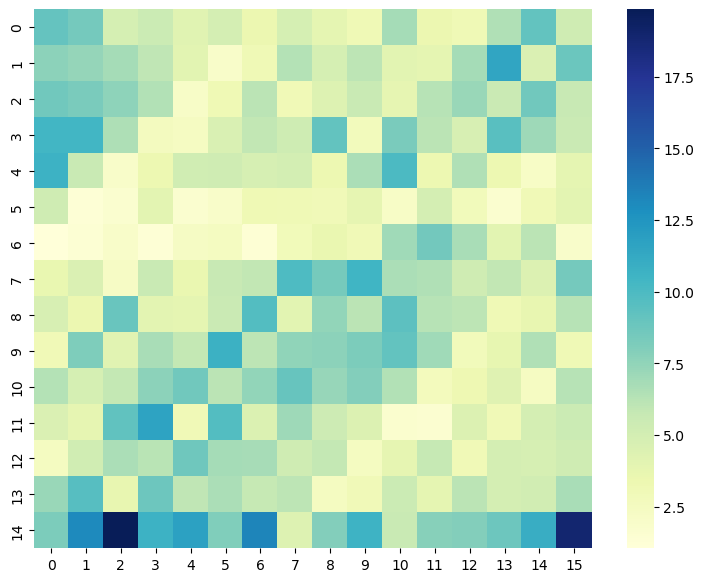

In [31]:
zones_to_remove = [6] #, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for zone_to_remove in zones_to_remove:
    print('Zone removed: ', zone_to_remove)
    # model = HeteroGNN(20, 1, 4)
    model = HeteroGNN_simplified(20, 1, 4)
    model.load_state_dict(torch.load(f"MNAV_HeteroGNN_simplified_without_{zone_to_remove}_best_model_2.pth"))
    model.to(device)

    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
    
    # VALIDATION
    model.eval()

    for data in test_loader:
        data = data.to(device)
        data.x_dict["aps"].requires_grad_()
        data.x_dict["zones"].requires_grad_()        
        out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
        out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)

        scores = (out_zones.gather(1, data["zones"].y.cpu().view(-1, 1).type(torch.long)).squeeze())
        scores.backward(torch.FloatTensor([1.0]*scores.shape[0]))
        saliency, _ = torch.max(data.x_dict["aps"].grad.data.abs(), dim=1)

        
        output = m(out_zones)
        print(classification_report(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))
        
        for zone in range(num_classes):
            # mask_gt = data["zones"].y.cpu() == zone
            # saliency_removed_zone = saliency.reshape((len(test_dataset),num_aps))[mask_gt]
            # sal = np.mean(saliency_removed_zone.cpu().numpy(), axis=0).reshape(num_aps,1)

            mask_pred = np.array(torch.argmax(output.cpu(), axis=1)) == zone
            saliency_removed_zone_pred = saliency.reshape((len(test_dataset),num_aps))[mask_pred]
            sal = np.mean(saliency_removed_zone_pred.cpu().numpy(), axis=0).reshape(num_aps,1)
            if zone == 0:
                sal_stack = sal
            else:
                sal_stack = np.concatenate((sal_stack, sal))

        
        # import ipdb; ipdb.set_trace()
        
        # plt.figure(figsize=[9,7])
        # cf_matrix = confusion_matrix(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1)), normalize="true")
        # sns.heatmap(cf_matrix, annot=True, fmt=".0%", cmap="YlGnBu", vmin=0, vmax=0.2, cbar=False)
        # plt.figure(figsize=[9,7])
        # sns.heatmap(saliency_removed_zone.cpu().numpy(), annot=False, fmt=".0%", cmap="YlGnBu", cbar=True)
        plt.figure(figsize=[9,7])
        sns.heatmap(sal_stack.reshape((15,num_classes)), annot=False, fmt=".0%", cmap="YlGnBu", cbar=True)        

### Grafo con una zona menos

In [32]:
zone_to_remove = 14

In [33]:
# Split de los datos y armado del objeto Data con el grafo

X_train, X_test, y_train, y_test, num_aps, num_classes, enc_train = preprocess_dataset(dataset, zone_to_remove=zone_to_remove)
ap_edge_index, ap_edge_attr = ap_graph_creator(X_train[:,:15], th=10) #el grafo lo armo solo con los datos de 2.4Ghz
zone_ap_edge_index, zone_ap_edge_attr = zone_ap_graph_creator(X_train[:,:15], y_train, zone_to_remove=zone_to_remove) #el grafo lo armo solo con los datos de 2.4Ghz
data = build_heterodata(ap_edge_index, ap_edge_attr, zone_ap_edge_index, zone_ap_edge_attr, num_classes)
T.ToUndirected()(data)

[array(['location_1', 'location_10', 'location_11', 'location_12',
       'location_13', 'location_14', 'location_15', 'location_16',
       'location_2', 'location_3', 'location_4', 'location_5',
       'location_6', 'location_7', 'location_8', 'location_9'],
      dtype=object)]
X_train shape:  (8375, 30)


HeteroData(
  aps={ num_nodes=15 },
  zones={ num_nodes=16 },
  (aps, ap_ap, aps)={
    edge_index=[2, 210],
    edge_attr=[210, 1]
  },
  (zones, zone_ap, aps)={
    edge_index=[2, 233],
    edge_attr=[233, 1]
  },
  (aps, rev_zone_ap, zones)={
    edge_index=[2, 233],
    edge_attr=[233, 1]
  }
)

In [34]:
# Armado del dataset

x_training_data = np.reshape(X_train,(X_train.shape[0],15,2))
x_test_data = np.reshape(X_test,(X_test.shape[0],15,2))
y_training_data = y_train
y_test_data = y_test

#normalize (x-mean)/std
mean = x_training_data.mean(axis=0)
std = x_training_data.std(axis=0)

x_training_data = x_training_data - mean
x_training_data /= std
x_test_data = x_test_data - mean
x_test_data /= std

In [35]:
train_dataset = build_dataset(x_training_data, y_training_data, data, zone_to_remove)
test_dataset = build_dataset(x_test_data, y_test_data, data, zone_to_remove)

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [37]:
batch_size = 16
learning_rate = 0.01

In [38]:
# model = HeteroGNN(20, 1, 4).to(device)
model = HeteroGNN_simplified(20, 1, 4).to(device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
loss = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
print_every = 5

Epoch 5, Train Loss 0.913398802280426, Val Loss 0.7834773659706116
Epoch 10, Train Loss 0.5863134264945984, Val Loss 1.216668725013733
Epoch 15, Train Loss 0.45776939392089844, Val Loss 1.1149235963821411
Epoch 20, Train Loss 0.668139636516571, Val Loss 0.7822443246841431
Epoch 25, Train Loss 0.26792004704475403, Val Loss 0.5652636289596558
Epoch 30, Train Loss 0.5831670165061951, Val Loss 0.42127475142478943
Epoch 35, Train Loss 0.21870824694633484, Val Loss 0.21652105450630188
Epoch 40, Train Loss 0.2791878283023834, Val Loss 0.2818174660205841
Epoch 45, Train Loss 0.17977496981620789, Val Loss 0.3070118725299835
Epoch 50, Train Loss 0.16598506271839142, Val Loss 0.28634798526763916
Epoch 55, Train Loss 0.15063267946243286, Val Loss 0.2043921947479248
Epoch 60, Train Loss 0.1883213222026825, Val Loss 0.1703384965658188
Epoch 65, Train Loss 0.10930239409208298, Val Loss 0.23293007910251617
Epoch 70, Train Loss 0.1569935828447342, Val Loss 0.17476709187030792
Epoch 75, Train Loss 0.167

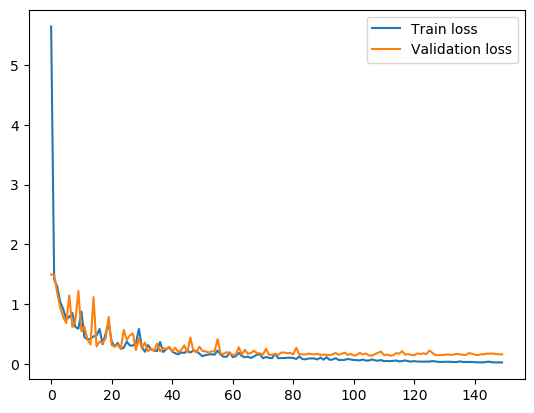

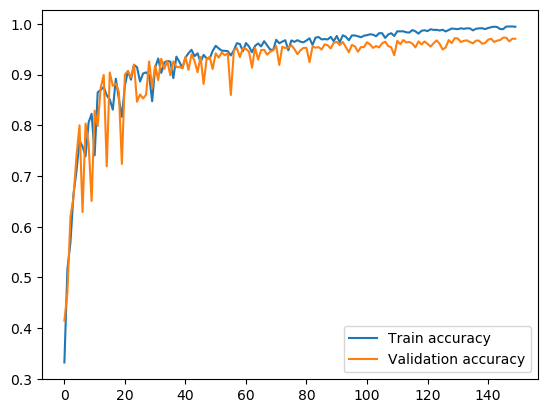

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       112
           1       0.98      0.97      0.98       127
           2       1.00      0.96      0.98        81
           3       0.96      0.96      0.96        82
           4       0.95      0.98      0.97        85
           5       0.95      0.96      0.95        98
           6       0.96      0.95      0.95        95
           7       1.00      0.99      0.99        87
           8       0.96      0.96      0.96        73
           9       0.95      0.96      0.96       219
          10       0.98      0.95      0.97       163
          11       0.95      0.96      0.95       194
          12       0.98      1.00      0.99       114
          13       0.98      0.98      0.98       227
          14       0.00      0.00      0.00         0
          15       1.00      1.00      1.00       118

    accuracy                           0.97      1875
   macro avg       0.91   

/home/fede/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fede/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fede/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
best_test_accuracy = 0


m = torch.nn.Softmax(dim=1)

for epoch in range(150):
    # print(f"Epoch: {epoch+1}")
    
    # TRAIN
    model.train()
    train_accuracy_epoch = []
    train_loss_epoch = []
    for data in train_loader:
        # import ipdb; ipdb.set_trace()
        
        data = data.to(device)
        
        out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
        
        out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)
        loss_result = loss(out_zones.cpu(), data["zones"].y.cpu().type(torch.long))
        loss_result.backward()
        train_loss_epoch.append(loss_result.detach().cpu())
        
        optimizer.step()
        optimizer.zero_grad()

        output = m(out_zones)
        train_accuracy_epoch.append(accuracy_score(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))

    # if scheduler.get_last_lr()[0] > 0.0005:
    if (epoch+1)%10 == 0:
        scheduler.step()

    train_accuracy.append(np.mean(train_accuracy_epoch))
    train_loss.append(np.mean(train_loss_epoch))
    
    
    
    # VALIDATION
    model.eval()
    test_accuracy_epoch = []
    test_loss_epoch = []
    for data in test_loader:
        
        data = data.to(device)
        out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
        # out_zones = torch.mean(out["zones"].cpu(),1)
        # out_zones = out_zones.reshape(out_zones.shape[0]//num_classes,num_classes)
        out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)

        # out_zones = out.cpu().reshape(out.cpu().shape[0]//num_classes,num_classes)
        
        loss_result = loss(out_zones.cpu(), data["zones"].y.cpu().type(torch.long))        
        test_loss_epoch.append(loss_result.detach().cpu())
        
        output = m(out_zones)
        test_accuracy_epoch.append(accuracy_score(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))

    test_accuracy.append(np.mean(test_accuracy_epoch))
    if test_accuracy[-1] > best_test_accuracy:
        best_test_accuracy = test_accuracy[-1]        
        torch.save(model.state_dict(), "MNAV_HeteroGNN_removed_zone_best_model_2.pth")
        
    test_loss.append(np.mean(test_loss_epoch))

    if (epoch+1)%print_every == 0:
        print(f"Epoch {epoch+1}, Train Loss {np.mean(train_loss_epoch)}, Val Loss {np.mean(test_loss_epoch)}")
    
print(f"Last LR: {scheduler.get_last_lr()}")
print(f"Best Accuracy: Train {np.max(train_accuracy)}, Val {np.max(test_accuracy)}")

plt.figure()
plt.plot(train_loss, label="Train loss")
plt.plot(test_loss, label="Validation loss")
plt.legend()

plt.figure()
plt.plot(train_accuracy, label="Train accuracy")
plt.plot(test_accuracy, label="Validation accuracy")
plt.legend()

plt.show()

print(classification_report(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))

### Test con todas las zonas

In [40]:
# Split de los datos y armado del objeto Data con el grafo

X_train, X_test, y_train, y_test, num_aps, num_classes, enc_train = preprocess_dataset(dataset)
ap_edge_index, ap_edge_attr = ap_graph_creator(X_train[:,:15], th=10) #el grafo lo armo solo con los datos de 2.4Ghz
zone_ap_edge_index, zone_ap_edge_attr = zone_ap_graph_creator(X_train[:,:15], y_train) #el grafo lo armo solo con los datos de 2.4Ghz
data = build_heterodata(ap_edge_index, ap_edge_attr, zone_ap_edge_index, zone_ap_edge_attr)
T.ToUndirected()(data)

[array(['location_1', 'location_10', 'location_11', 'location_12',
       'location_13', 'location_14', 'location_15', 'location_16',
       'location_2', 'location_3', 'location_4', 'location_5',
       'location_6', 'location_7', 'location_8', 'location_9'],
      dtype=object)]
X_train shape:  (8375, 30)


HeteroData(
  aps={ num_nodes=15 },
  zones={ num_nodes=16 },
  (aps, ap_ap, aps)={
    edge_index=[2, 210],
    edge_attr=[210, 1]
  },
  (zones, zone_ap, aps)={
    edge_index=[2, 233],
    edge_attr=[233, 1]
  },
  (aps, rev_zone_ap, zones)={
    edge_index=[2, 233],
    edge_attr=[233, 1]
  }
)

In [41]:
# Armado del dataset

x_training_data = np.reshape(X_train,(X_train.shape[0],15,2))
x_test_data = np.reshape(X_test,(X_test.shape[0],15,2))
y_training_data = y_train
y_test_data = y_test

#normalize (x-mean)/std
mean = x_training_data.mean(axis=0)
std = x_training_data.std(axis=0)

x_training_data = x_training_data - mean
x_training_data /= std
x_test_data = x_test_data - mean
x_test_data /= std

In [42]:
train_dataset = build_dataset(x_training_data, y_training_data, data)
test_dataset = build_dataset(x_test_data, y_test_data, data)

mean

In [44]:
for zone_to_remove in zones_to_remove:
    print('Zone removed: ', zone_to_remove)
    # model = HeteroGNN(20, 1, 4)
    model = HeteroGNN_simplified(20, 1, 4)
    model.load_state_dict(torch.load(f"MNAV_HeteroGNN_simplified_without_{zone_to_remove}_best_model_2.pth"))
    model.to(device)

    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
    
    # VALIDATION
    model.eval()

    for data in test_loader:
        data = data.to(device)
        out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
        out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)

        output = m(out_zones)
        print(classification_report(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))    

Zone removed:  6
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       112
           1       0.98      0.94      0.96       127
           2       1.00      0.95      0.97        81
           3       0.99      0.96      0.98        82
           4       0.94      1.00      0.97        85
           5       0.65      1.00      0.79        98
           6       1.00      0.23      0.38        95
           7       0.97      0.99      0.98        87
           8       0.95      0.97      0.96        73
           9       0.94      0.95      0.94       219
          10       0.93      0.97      0.95       163
          11       0.95      0.93      0.94       194
          12       0.81      0.89      0.85       114
          13       0.88      0.90      0.89       227
          14       0.85      0.87      0.86       219
          15       0.98      1.00      0.99       118

    accuracy                           0.91      2094
   macro 

zona 15

In [45]:
# VALIDATION
model.eval()

for data in test_loader:
    data = data.to(device)
    out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
    out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)

    output = m(out_zones)
    print(classification_report(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))
    

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       112
           1       0.98      0.94      0.96       127
           2       1.00      0.95      0.97        81
           3       0.99      0.96      0.98        82
           4       0.94      1.00      0.97        85
           5       0.65      1.00      0.79        98
           6       1.00      0.23      0.38        95
           7       0.97      0.99      0.98        87
           8       0.95      0.97      0.96        73
           9       0.94      0.95      0.94       219
          10       0.93      0.97      0.95       163
          11       0.95      0.93      0.94       194
          12       0.81      0.89      0.85       114
          13       0.88      0.90      0.89       227
          14       0.85      0.87      0.86       219
          15       0.98      1.00      0.99       118

    accuracy                           0.91      2094
   macro avg       0.92   

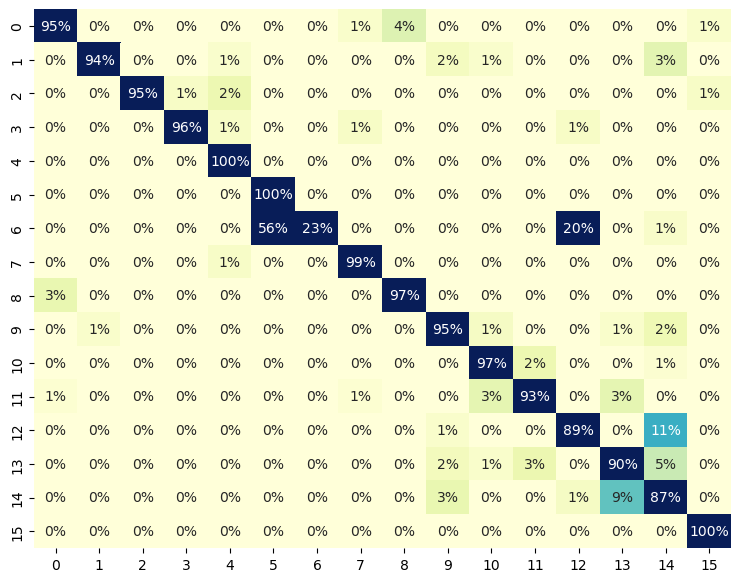

In [46]:
plt.figure(figsize=[9,7])
cf_matrix = confusion_matrix(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1)), normalize="true")
sns.heatmap(cf_matrix, annot=True, fmt=".0%", cmap="YlGnBu", vmin=0, vmax=0.2, cbar=False)


zona 14

In [47]:
# VALIDATION
model.eval()

for data in test_loader:
    data = data.to(device)
    out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
    out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)

    output = m(out_zones)
    print(classification_report(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))
    

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       112
           1       0.98      0.94      0.96       127
           2       1.00      0.95      0.97        81
           3       0.99      0.96      0.98        82
           4       0.94      1.00      0.97        85
           5       0.65      1.00      0.79        98
           6       1.00      0.23      0.38        95
           7       0.97      0.99      0.98        87
           8       0.95      0.97      0.96        73
           9       0.94      0.95      0.94       219
          10       0.93      0.97      0.95       163
          11       0.95      0.93      0.94       194
          12       0.81      0.89      0.85       114
          13       0.88      0.90      0.89       227
          14       0.85      0.87      0.86       219
          15       0.98      1.00      0.99       118

    accuracy                           0.91      2094
   macro avg       0.92   

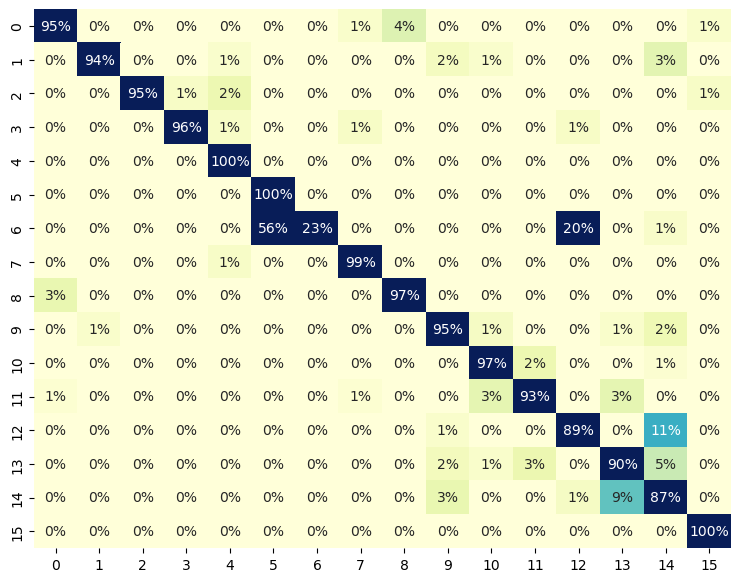

In [48]:
plt.figure(figsize=[9,7])
cf_matrix = confusion_matrix(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1)), normalize="true")
sns.heatmap(cf_matrix, annot=True, fmt=".0%", cmap="YlGnBu", vmin=0, vmax=0.2, cbar=False)


sum

In [49]:
for zone_to_remove in zones_to_remove:
    print('Zone removed: ', zone_to_remove)
    # model = HeteroGNN(20, 1, 4)
    model = HeteroGNN_simplified(20, 1, 4)
    model.load_state_dict(torch.load(f"MNAV_HeteroGNN_simplified_without_{zone_to_remove}_best_model_2.pth"))
    model.to(device)

    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
    
    # VALIDATION
    model.eval()

    for data in test_loader:
        data = data.to(device)
        out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
        out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)

        output = m(out_zones)
        print(classification_report(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))
        plt.figure(figsize=[9,7])
        cf_matrix = confusion_matrix(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1)), normalize="true")
        sns.heatmap(cf_matrix, annot=True, fmt=".0%", cmap="YlGnBu", vmin=0, vmax=0.2, cbar=False)

Zone removed:  6


FileNotFoundError: [Errno 2] No such file or directory: 'MNAV_HeteroGNN_simplified_without_6_best_model.pth'

## Análisis variando cantidad de muestras

### HeteroGNN

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16
learning_rate = 0.01  
print_every = 5

porcentajes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
accuracy = {"0.1":[], "0.2":[], "0.3":[], "0.4":[], "0.5":[], "0.6":[], "0.7":[], "0.8":[], "0.9":[], "1":[]}

for porc in porcentajes:
    print('Porcentaje de datos: ', porc)
    
    for i in range(10):    

        # Split de los datos y armado del objeto Data con el grafo
        X_train, X_test, y_train, y_test, num_aps, num_classes, enc_train = preprocess_dataset(dataset, dataset_percentage=porc)
        ap_edge_index, ap_edge_attr = ap_graph_creator(X_train[:,:15], th=10, prune_th=10) #el grafo lo armo solo con los datos de 2.4Ghz
        zone_ap_edge_index, zone_ap_edge_attr = zone_ap_graph_creator(X_train[:,:15], y_train, prune_th=10) #el grafo lo armo solo con los datos de 2.4Ghz
        data = build_heterodata(ap_edge_index, ap_edge_attr, zone_ap_edge_index, zone_ap_edge_attr, num_classes)
        T.ToUndirected()(data)

        # Armado del dataset

        x_training_data = np.reshape(X_train,(X_train.shape[0],15,2))
        x_test_data = np.reshape(X_test,(X_test.shape[0],15,2))
        y_training_data = y_train
        y_test_data = y_test

        #normalize (x-mean)/std
        mean = x_training_data.mean(axis=0)
        std = x_training_data.std(axis=0)

        x_training_data = x_training_data - mean
        x_training_data /= std
        x_test_data = x_test_data - mean
        x_test_data /= std   

        train_dataset = build_dataset(x_training_data, y_training_data, data)
        test_dataset = build_dataset(x_test_data, y_test_data, data) 

        model = HeteroGNN(20, 1, 4).to(device)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
        loss = torch.nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

        train_loss = []
        train_accuracy = []
        test_loss = []
        test_accuracy = []
        best_test_accuracy = 0

        m = torch.nn.Softmax(dim=1)

        for epoch in range(150):
            # print(f"Epoch: {epoch+1}")

            # TRAIN
            model.train()
            train_accuracy_epoch = []
            train_loss_epoch = []
            for data in train_loader:
                # import ipdb; ipdb.set_trace()

                data = data.to(device)

                out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 

                out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)
                loss_result = loss(out_zones.cpu(), data["zones"].y.cpu().type(torch.long))
                loss_result.backward()
                train_loss_epoch.append(loss_result.detach().cpu())

                optimizer.step()
                optimizer.zero_grad()

                output = m(out_zones)
                train_accuracy_epoch.append(accuracy_score(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))

            # if scheduler.get_last_lr()[0] > 0.0005:
            if (epoch+1)%10 == 0:
                scheduler.step()

            train_accuracy.append(np.mean(train_accuracy_epoch))
            train_loss.append(np.mean(train_loss_epoch))

            # VALIDATION
            model.eval()
            test_accuracy_epoch = []
            test_loss_epoch = []
            for data in test_loader:

                data = data.to(device)
                out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
                # out_zones = torch.mean(out["zones"].cpu(),1)
                # out_zones = out_zones.reshape(out_zones.shape[0]//num_classes,num_classes)
                out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)

                # out_zones = out.cpu().reshape(out.cpu().shape[0]//num_classes,num_classes)

                loss_result = loss(out_zones.cpu(), data["zones"].y.cpu().type(torch.long))        
                test_loss_epoch.append(loss_result.detach().cpu())

                output = m(out_zones)
                test_accuracy_epoch.append(accuracy_score(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))

            test_accuracy.append(np.mean(test_accuracy_epoch))
            test_loss.append(np.mean(test_loss_epoch))

        print(f"Best Accuracy: Train {np.max(train_accuracy)}, Val {np.max(test_accuracy)}")
        accuracy[str(porc)].append(np.max(test_accuracy))

In [ ]:
accuracy

In [ ]:
accuracy = {'0.3': [0.9364069952305246, 0.9268680445151033, 0.918918918918919, 0.9364069952305246, 0.9364069952305246], '0.4': [0.9534606205250596, 0.9486873508353222, 0.9486873508353222, 0.951073985680191, 0.9427207637231504], '0.5': [0.9474689589302769, 0.9398280802292264, 0.944603629417383, 0.944603629417383, 0.9474689589302769], '0.6': [0.954653937947494, 0.964200477326969, 0.964200477326969, 0.9562450278440732, 0.9578361177406524], '0.7': [0.9577080491132333, 0.9604365620736699, 0.9624829467939973, 0.961118690313779, 0.9556616643929059], '0.8': [0.9498507462686567, 0.9552238805970149, 0.9582089552238806, 0.955820895522388, 0.955820895522388], '0.9': [0.9639257294429708, 0.9612732095490716, 0.9671087533156498, 0.96657824933687, 0.96657824933687], '1': [0.9737344794651385, 0.9713467048710601, 0.9737344794651385, 0.9746895893027698, 0.9680038204393505]}

In [ ]:
aux = []
aux.append(accuracy['0.3'])
aux.append(accuracy['0.4'])
aux.append(accuracy['0.5'])
aux.append(accuracy['0.6'])
aux.append(accuracy['0.7'])
aux.append(accuracy['0.8'])
aux.append(accuracy['0.9'])
aux.append(accuracy['1'])

In [ ]:
plt.figure(figsize=[9,7])
plt.boxplot(aux, showfliers=False) #, meanline=True, showmeans=True)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], [30, 40, 50, 60, 70, 80, 90, 100])
plt.ylabel('Accuracy')
plt.xlabel('Fingerprints sample size (%)')
plt.grid()
plt.savefig('MNAV_hetero_cant_muestras.pdf')

### HeteroGNNSimplified

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16
learning_rate = 0.01  
print_every = 5

porcentajes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
accuracy = {"0.1":[], "0.2":[], "0.3":[], "0.4":[], "0.5":[], "0.6":[], "0.7":[], "0.8":[], "0.9":[], "1":[]}

for porc in porcentajes:
    print('Porcentaje de datos: ', porc)   
    
    for i in range(10):    
        
        # Split de los datos y armado del objeto Data con el grafo
        X_train, X_test, y_train, y_test, num_aps, num_classes, enc_train = preprocess_dataset(dataset, dataset_percentage=porc)
        ap_edge_index, ap_edge_attr = ap_graph_creator(X_train[:,:15], th=10) #el grafo lo armo solo con los datos de 2.4Ghz
        zone_ap_edge_index, zone_ap_edge_attr = zone_ap_graph_creator(X_train[:,:15], y_train) #el grafo lo armo solo con los datos de 2.4Ghz
        data = build_heterodata(ap_edge_index, ap_edge_attr, zone_ap_edge_index, zone_ap_edge_attr, num_classes)
        T.ToUndirected()(data)

        # Armado del dataset

        x_training_data = np.reshape(X_train,(X_train.shape[0],15,2))
        x_test_data = np.reshape(X_test,(X_test.shape[0],15,2))
        y_training_data = y_train
        y_test_data = y_test

        #normalize (x-mean)/std
        mean = x_training_data.mean(axis=0)
        std = x_training_data.std(axis=0)

        x_training_data = x_training_data - mean
        x_training_data /= std
        x_test_data = x_test_data - mean
        x_test_data /= std   

        train_dataset = build_dataset(x_training_data, y_training_data, data)
        test_dataset = build_dataset(x_test_data, y_test_data, data)  

        model = HeteroGNN_simplified(20, 1, 4).to(device)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
        loss = torch.nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

        train_loss = []
        train_accuracy = []
        test_loss = []
        test_accuracy = []
        best_test_accuracy = 0

        m = torch.nn.Softmax(dim=1)

        for epoch in range(150):
            # print(f"Epoch: {epoch+1}")

            # TRAIN
            model.train()
            train_accuracy_epoch = []
            train_loss_epoch = []
            for data in train_loader:
                # import ipdb; ipdb.set_trace()

                data = data.to(device)

                out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 

                out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)
                loss_result = loss(out_zones.cpu(), data["zones"].y.cpu().type(torch.long))
                loss_result.backward()
                train_loss_epoch.append(loss_result.detach().cpu())

                optimizer.step()
                optimizer.zero_grad()

                output = m(out_zones)
                train_accuracy_epoch.append(accuracy_score(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))

            # if scheduler.get_last_lr()[0] > 0.0005:
            if (epoch+1)%10 == 0:
                scheduler.step()

            train_accuracy.append(np.mean(train_accuracy_epoch))
            train_loss.append(np.mean(train_loss_epoch))

            # VALIDATION
            model.eval()
            test_accuracy_epoch = []
            test_loss_epoch = []
            for data in test_loader:

                data = data.to(device)
                out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
                # out_zones = torch.mean(out["zones"].cpu(),1)
                # out_zones = out_zones.reshape(out_zones.shape[0]//num_classes,num_classes)
                out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)

                # out_zones = out.cpu().reshape(out.cpu().shape[0]//num_classes,num_classes)

                loss_result = loss(out_zones.cpu(), data["zones"].y.cpu().type(torch.long))        
                test_loss_epoch.append(loss_result.detach().cpu())

                output = m(out_zones)
                test_accuracy_epoch.append(accuracy_score(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))

            test_accuracy.append(np.mean(test_accuracy_epoch))
            test_loss.append(np.mean(test_loss_epoch))

        print(f"Best Accuracy: Train {np.max(train_accuracy)}, Val {np.max(test_accuracy)}")
        accuracy[str(porc)].append(np.max(test_accuracy))
print(accuracy)

## Análisis variando cantidad de APs

In [ ]:
APs_MAC_2_4 = ['wifi-dc:a5:f4:43:85:c0',
'wifi-dc:a5:f4:43:27:e0',
'wifi-f8:4f:57:ab:da:00',
'wifi-5c:a4:8a:4c:05:c0',
'wifi-1c:1d:86:ce:ef:b0',
'wifi-dc:a5:f4:43:79:20',
'wifi-c0:7b:bc:36:9e:10',
'wifi-1c:1d:86:9f:99:20',
'wifi-c0:7b:bc:36:af:40',
'wifi-c0:7b:bc:36:af:80',
'wifi-1c:1d:86:b6:ac:80',
'wifi-dc:a5:f4:43:72:e0',
'wifi-f8:4f:57:ab:d8:60',
'wifi-dc:a5:f4:43:72:90',
'wifi-f8:4f:57:ab:ce:20']

APs_MAC_5 = ['wifi-dc:a5:f4:45:85:b0',
'wifi-dc:a5:f4:45:27:e0',
'wifi-f8:4f:57:ad:d9:60',
'wifi-5c:a4:8a:4e:05:30',
'wifi-1c:1d:86:d0:ef:00',
'wifi-dc:a5:f4:45:79:10',
'wifi-c0:7b:bc:38:9e:00',
'wifi-1c:1d:86:a1:99:00',
'wifi-c0:7b:bc:38:af:30',
'wifi-c0:7b:bc:38:af:70',
'wifi-1c:1d:86:b8:ac:80',
'wifi-dc:a5:f4:45:72:d0',
'wifi-f8:4f:57:ad:d7:c0',
'wifi-dc:a5:f4:45:72:80',
'wifi-f8:4f:57:ad:cd:80']

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 8
learning_rate = 0.001  
print_every = 5

aps = ['AP1', 'AP2', 'AP3', 'AP4', 'AP5', 'AP6', 'AP7', 'AP8', 'AP9', 'AP10', 'AP11', 'AP12', 'AP13', 'AP14', 'AP15']
APs_to_remove = [12] #, 9, 13, 2, 7] 
accuracy = {}

for ap in APs_to_remove:
    print('Nuevo AP removido: ', ap)
    APs_MAC_2_4.pop(ap)
    APs_MAC_5.pop(ap)
    aps.pop(ap)
    
    # Split de los datos y armado del objeto Data con el grafo
    X_train, X_test, y_train, y_test, num_aps, num_classes, enc_train = preprocess_dataset(dataset)
    ap_edge_index, ap_edge_attr = ap_graph_creator(X_train[:,:len(aps)], th=10, cols=aps) #el grafo lo armo solo con los datos de 2.4Ghz
    zone_ap_edge_index, zone_ap_edge_attr = zone_ap_graph_creator(X_train[:,:len(aps)], y_train, cols=aps) #el grafo lo armo solo con los datos de 2.4Ghz
    data = build_heterodata(ap_edge_index, ap_edge_attr, zone_ap_edge_index, zone_ap_edge_attr, num_classes)
    T.ToUndirected()(data)
    
    # Armado del dataset

    x_training_data = np.reshape(X_train,(X_train.shape[0],len(aps),2))
    x_test_data = np.reshape(X_test,(X_test.shape[0],len(aps),2))
    y_training_data = y_train
    y_test_data = y_test

    #normalize (x-mean)/std
    mean = x_training_data.mean(axis=0)
    std = x_training_data.std(axis=0)

    x_training_data = x_training_data - mean
    x_training_data /= std
    x_test_data = x_test_data - mean
    x_test_data /= std   
    
    train_dataset = build_dataset(x_training_data, y_training_data, data)
    test_dataset = build_dataset(x_test_data, y_test_data, data) 
  
    model = HeteroGNN(20, 1, 4) #.to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
    loss = torch.nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
    
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []
    best_test_accuracy = 0

    m = torch.nn.Softmax(dim=1)

    for epoch in range(100):
        # print(f"Epoch: {epoch+1}")

        # TRAIN
        model.train()
        train_accuracy_epoch = []
        train_loss_epoch = []
        for data in train_loader:
            import ipdb; ipdb.set_trace()

            # data = data.to(device)

            out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 

            out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)
            loss_result = loss(out_zones.cpu(), data["zones"].y.cpu().type(torch.long))
            loss_result.backward()
            train_loss_epoch.append(loss_result.detach().cpu())

            optimizer.step()
            optimizer.zero_grad()

            output = m(out_zones)
            train_accuracy_epoch.append(accuracy_score(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))

        # if scheduler.get_last_lr()[0] > 0.0005:
        if (epoch+1)%20 == 0:
            scheduler.step()

        train_accuracy.append(np.mean(train_accuracy_epoch))
        train_loss.append(np.mean(train_loss_epoch))

        # VALIDATION
        model.eval()
        test_accuracy_epoch = []
        test_loss_epoch = []
        for data in test_loader:

            data = data.to(device)
            out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
            # out_zones = torch.mean(out["zones"].cpu(),1)
            # out_zones = out_zones.reshape(out_zones.shape[0]//num_classes,num_classes)
            out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)

            # out_zones = out.cpu().reshape(out.cpu().shape[0]//num_classes,num_classes)

            loss_result = loss(out_zones.cpu(), data["zones"].y.cpu().type(torch.long))        
            test_loss_epoch.append(loss_result.detach().cpu())

            output = m(out_zones)
            test_accuracy_epoch.append(accuracy_score(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))

        test_accuracy.append(np.mean(test_accuracy_epoch))
        test_loss.append(np.mean(test_loss_epoch))

    print(f"Best Accuracy: Train {np.max(train_accuracy)}, Val {np.max(test_accuracy)}")
    accuracy[str(porc)] = np.max(test_accuracy)
    
    plt.figure()
    plt.plot(train_loss, label="Train loss")
    plt.plot(test_loss, label="Validation loss")
    plt.legend()

    plt.figure()
    plt.plot(train_accuracy, label="Train accuracy")
    plt.plot(test_accuracy, label="Validation accuracy")
    plt.legend()

    plt.show()    

print(accuracy)

## Análisis de APs caídos

Entreno normalmente y después testeo con APs caídos.

In [ ]:
device = torch.device('cuda:1')

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lst = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
accuracy_ap_caido_gnn = {"1":[], "2":[], "3":[]}

m = torch.nn.Softmax(dim=1)

for ap in [1,2,3]:
    print("Cantidad de APs caídos: ", ap)

    for combo in combinations(lst, ap):  # 2 for pairs, 3 for triplets, etc
        # Split de los datos y armado del objeto Data con el grafo

        X_train, X_test, y_train, y_test, num_aps, num_classes, enc_train = preprocess_dataset(dataset)
        ap_edge_index, ap_edge_attr = ap_graph_creator(X_train[:,:15], th=10, prune_th=10) #el grafo lo armo solo con los datos de 2.4Ghz
        zone_ap_edge_index, zone_ap_edge_attr = zone_ap_graph_creator(X_train[:,:15], y_train, prune_th=10) #el grafo lo armo solo con los datos de 2.4Ghz
        data = build_heterodata(ap_edge_index, ap_edge_attr, zone_ap_edge_index, zone_ap_edge_attr)
        T.ToUndirected()(data)

        # Armado del dataset

        x_training_data = np.reshape(X_train,(X_train.shape[0],15,2))
        x_test_data = np.reshape(X_test,(X_test.shape[0],15,2))
        y_training_data = y_train
        y_test_data = y_test

        #normalize (x-mean)/std
        mean = x_training_data.mean(axis=0)
        std = x_training_data.std(axis=0)

        x_training_data = x_training_data - mean
        x_training_data /= std
        x_test_data = x_test_data - mean
        x_test_data /= std     

        for i in combo:        
            x_test_data[:,i] = 0

        test_dataset = build_dataset(x_test_data, y_test_data, data)     

        model = HeteroGNN(20, 1, 4)
        model.load_state_dict(torch.load("MNAV_HeteroGNN_best_model_968.pth"))
        model.to(device)
        test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)  

        # TEST
        model.eval()
        for data in test_loader:
            data = data.to(device)
            out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
            out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)

            output = m(out_zones)
        accuracy_ap_caido_gnn[str(ap)].append(accuracy_score(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))
        print(accuracy_ap_caido_gnn[str(ap)][-1])
    print(f"    Accuracy promedio: {np.mean(accuracy_ap_caido_gnn[str(ap)])}")

            

In [ ]:
accuracy_ap_caido_gnn

In [ ]:
for ap in [1,2,3]:
    print(f"{ap}: {np.mean(accuracy_ap_caido_gnn[str(ap)])}")

### KNN

In [ ]:
lst = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
X_train, X_test, y_train, y_test, num_aps, num_classes, enc_train = preprocess_dataset(dataset)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

accuracy_ap_caido_knn = {"1":[], "2":[], "3":[]}

for ap in [1,2,3]:
    print("Cantidad de APs caídos: ", ap)
    for combo in combinations(lst, ap):  # 2 for pairs, 3 for triplets, etc
        X_aux_test = deepcopy(X_test)
        for i in combo:
            X_aux_test[:,i] = 0
            X_aux_test[:,i+15] = 0

        y_pred_knn = neigh.predict(X_aux_test)

        ACC_test = accuracy_score(y_test, y_pred_knn)
        accuracy_ap_caido_knn[str(ap)].append(ACC_test)
    print("    Accuracy: ", np.mean(accuracy_ap_caido_knn[str(ap)]))



In [ ]:
accuracy_ap_caido_knn

## Análisis de obstáculos

In [ ]:
device = torch.device('cuda:1')

lst = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
obstaculo_gnn_hetero = {"5":[], "10":[], "15":[]}
obstaculos = [-5] #[-10, -15] # dB

m = torch.nn.Softmax(dim=1)

for obstaculo in obstaculos:
    print(f"Obstáculo: {obstaculo}")

    for ap in lst:
        
        # Split de los datos y armado del objeto Data con el grafo        
        X_train, X_test, y_train, y_test, num_aps, num_classes, enc_train = preprocess_dataset(dataset)
        ap_edge_index, ap_edge_attr = ap_graph_creator(X_train[:,:15], th=10, prune_th=10) #el grafo lo armo solo con los datos de 2.4Ghz
        zone_ap_edge_index, zone_ap_edge_attr = zone_ap_graph_creator(X_train[:,:15], y_train, prune_th=10) #el grafo lo armo solo con los datos de 2.4Ghz
        data = build_heterodata(ap_edge_index, ap_edge_attr, zone_ap_edge_index, zone_ap_edge_attr)
        T.ToUndirected()(data)
        
        # Armado del dataset

        x_training_data = np.reshape(X_train,(X_train.shape[0],15,2))
        x_test_data = np.reshape(X_test,(X_test.shape[0],15,2))
        y_training_data = y_train
        y_test_data = y_test

        x_test_data[:,ap] += obstaculo
        
        #normalize (x-mean)/std
        mean = x_training_data.mean(axis=0)
        std = x_training_data.std(axis=0)

        x_training_data = x_training_data - mean
        x_training_data /= std
        x_test_data = x_test_data - mean
        x_test_data /= std     

        test_dataset = build_dataset(x_test_data, y_test_data, data)     

        model = HeteroGNN(20, 1, 4)
        model.load_state_dict(torch.load("MNAV_HeteroGNN_best_model_968.pth"))
        model.to(device)
        test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)  

        # TEST
        model.eval()
        for data in test_loader:
            data = data.to(device)
            out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
            out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)

            output = m(out_zones)
        obstaculo_gnn_hetero[str(abs(obstaculo))].append(accuracy_score(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))
            

In [ ]:
obstaculo_gnn_hetero

### Cambio en GSO

In [ ]:
device = torch.device('cuda:1')

lst = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
obstaculo_gnn_hetero_gso = {"5":[], "10":[], "15":[]}
obstaculos = [-5] # [-10, -15] # dB

m = torch.nn.Softmax(dim=1)

for obstaculo in obstaculos:
    print(f"Obstáculo: {obstaculo}")

    for ap in lst:
        
        # Split de los datos y armado del objeto Data con el grafo        
        X_train, X_test, y_train, y_test, num_aps, num_classes, enc_train = preprocess_dataset(dataset)

        # Build graph with modified fingerprints
        X_train[:,ap] += obstaculo
        X_train[:,ap+15] += obstaculo
        
        ap_edge_index, ap_edge_attr = ap_graph_creator(X_train[:,:15], th=10, prune_th=10) #el grafo lo armo solo con los datos de 2.4Ghz
        zone_ap_edge_index, zone_ap_edge_attr = zone_ap_graph_creator(X_train[:,:15], y_train, prune_th=10) #el grafo lo armo solo con los datos de 2.4Ghz
        data = build_heterodata(ap_edge_index, ap_edge_attr, zone_ap_edge_index, zone_ap_edge_attr)
        T.ToUndirected()(data)
        
        # Armado del dataset

        x_training_data = np.reshape(X_train,(X_train.shape[0],15,2))
        x_test_data = np.reshape(X_test,(X_test.shape[0],15,2))
        y_training_data = y_train
        y_test_data = y_test

        x_test_data[:,ap] += obstaculo
        
        #normalize (x-mean)/std
        mean = x_training_data.mean(axis=0)
        std = x_training_data.std(axis=0)

        x_training_data = x_training_data - mean
        x_training_data /= std
        x_test_data = x_test_data - mean
        x_test_data /= std     

        test_dataset = build_dataset(x_test_data, y_test_data, data)     

        model = HeteroGNN(20, 1, 4)
        model.load_state_dict(torch.load("MNAV_HeteroGNN_best_model_968.pth"))
        model.to(device)
        test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)  

        # TEST
        model.eval()
        for data in test_loader:
            data = data.to(device)
            out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
            out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)

            output = m(out_zones)
        obstaculo_gnn_hetero_gso[str(abs(obstaculo))].append(accuracy_score(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))
            

In [ ]:
obstaculo_gnn_hetero_gso

In [ ]:
obstaculo_gnn = {"10":[], "15":[]}
obstaculo_gnn["10"] = [0.9302769818529131, 0.9441260744985673, 0.9498567335243553, 0.938872970391595, 0.9379178605539638, 0.9336198662846227, 0.8720152817574021, 0.9326647564469914, 0.8667621776504298, 0.9274116523400191, 0.9274116523400191, 0.9383954154727794, 0.8046800382043935, 0.9450811843361987, 0.9097421203438395]
obstaculo_gnn["15"] = [0.887774594078319, 0.9240687679083095, 0.9422158548233047, 0.9149952244508118, 0.8982808022922636, 0.9097421203438395, 0.839541547277937, 0.899235912129895, 0.8166189111747851, 0.9063992359121299, 0.8863419293218721, 0.9250238777459407, 0.670487106017192, 0.9259789875835721, 0.8443170964660937]

obstaculo_knn = {"10":[], "15":[]}
obstaculo_knn["10"].append(0.9493791786055397)
obstaculo_knn["15"].append(0.9350525310410697)

obstaculo_knn["10"].append(0.944603629417383)
obstaculo_knn["15"].append(0.9369627507163324)

obstaculo_knn["10"].append(0.9479465138490927)
obstaculo_knn["15"].append(0.9288443170964661)

obstaculo_knn["10"].append(0.9412607449856734)
obstaculo_knn["15"].append(0.9202483285577842)

obstaculo_knn["10"].append(0.941738299904489)
obstaculo_knn["15"].append(0.9216809933142311)

obstaculo_knn["10"].append(0.9364851957975168)
obstaculo_knn["15"].append(0.9106972301814709)

obstaculo_knn["10"].append(0.9044890162368673)
obstaculo_knn["15"].append(0.8419293218720153)

obstaculo_knn["10"].append(0.9293218720152817)
obstaculo_knn["15"].append(0.89207258834766)

obstaculo_knn["10"].append(0.9063992359121299)
obstaculo_knn["15"].append(0.8462273161413563)

obstaculo_knn["10"].append(0.9278892072588347)
obstaculo_knn["15"].append(0.8954154727793696)

obstaculo_knn["10"].append(0.9293218720152817)
obstaculo_knn["15"].append(0.8810888252148997)

obstaculo_knn["10"].append(0.9240687679083095)
obstaculo_knn["15"].append(0.8720152817574021)

obstaculo_knn["10"].append(0.9493791786055397)
obstaculo_knn["15"].append(0.9383954154727794)

obstaculo_knn["10"].append(0.9498567335243553)
obstaculo_knn["15"].append(0.9336198662846227)

obstaculo_knn["10"].append(0.9551098376313276)
obstaculo_knn["15"].append(0.9484240687679083)

obstaculo_fcnn = {"10":[], "15":[]}

obstaculo_fcnn["10"].append(0.9188156638013372)
obstaculo_fcnn["15"].append(0.8533906399235912)
obstaculo_fcnn["10"].append(0.8767908309455588)
obstaculo_fcnn["15"].append(0.791308500477555)
obstaculo_fcnn["10"].append(0.8524355300859598)
obstaculo_fcnn["15"].append(0.7717287488061128)
obstaculo_fcnn["10"].append(0.8901623686723973)
obstaculo_fcnn["15"].append(0.8223495702005731)
obstaculo_fcnn["10"].append(0.8299904489016237)
obstaculo_fcnn["15"].append(0.7311365807067812)
obstaculo_fcnn["10"].append(0.8237822349570201)
obstaculo_fcnn["15"].append(0.7120343839541547)
obstaculo_fcnn["10"].append(0.7917860553963706)
obstaculo_fcnn["15"].append(0.6614135625596944)
obstaculo_fcnn["10"].append(0.9288443170964661)
obstaculo_fcnn["15"].append(0.8810888252148997)
obstaculo_fcnn["10"].append(0.8022922636103151)
obstaculo_fcnn["15"].append(0.6466093600764088)
obstaculo_fcnn["10"].append(0.8915950334288443)
obstaculo_fcnn["15"].append(0.7893982808022922)
obstaculo_fcnn["10"].append(0.893505253104107)
obstaculo_fcnn["15"].append(0.8166189111747851)
obstaculo_fcnn["10"].append(0.9001910219675263)
obstaculo_fcnn["15"].append(0.8314231136580706)
obstaculo_fcnn["10"].append(0.7717287488061128)
obstaculo_fcnn["15"].append(0.663323782234957)
obstaculo_fcnn["10"].append(0.779847182425979)
obstaculo_fcnn["15"].append(0.667621776504298)
obstaculo_fcnn["10"].append(0.7516714422158548)
obstaculo_fcnn["15"].append(0.6365807067812799)

obstaculo_bracco = {"10":[], "15":[]}

obstaculo_bracco["10"].append(0.9584527220630372)
obstaculo_bracco["15"].append(0.9489016236867239)
obstaculo_bracco["10"].append(0.9613180515759312)
obstaculo_bracco["15"].append(0.9527220630372493)
obstaculo_bracco["10"].append(0.9489016236867239)
obstaculo_bracco["15"].append(0.9321872015281757)
obstaculo_bracco["10"].append(0.9474689589302769)
obstaculo_bracco["15"].append(0.9245463228271251)
obstaculo_bracco["10"].append(0.9355300859598854)
obstaculo_bracco["15"].append(0.9044890162368673)
obstaculo_bracco["10"].append(0.9221585482330468)
obstaculo_bracco["15"].append(0.8787010506208214)
obstaculo_bracco["10"].append(0.8724928366762178)
obstaculo_bracco["15"].append(0.779847182425979)
obstaculo_bracco["10"].append(0.9469914040114613)
obstaculo_bracco["15"].append(0.9102196752626552)
obstaculo_bracco["10"].append(0.8801337153772684)
obstaculo_bracco["15"].append(0.7774594078319007)
obstaculo_bracco["10"].append(0.9522445081184336)
obstaculo_bracco["15"].append(0.9283667621776505)
obstaculo_bracco["10"].append(0.9383954154727794)
obstaculo_bracco["15"].append(0.8925501432664756)
obstaculo_bracco["10"].append(0.9216809933142311)
obstaculo_bracco["15"].append(0.8619866284622731)
obstaculo_bracco["10"].append(0.9527220630372493)
obstaculo_bracco["15"].append(0.9340974212034384)
obstaculo_bracco["10"].append(0.9398280802292264)
obstaculo_bracco["15"].append(0.9087870105062082)
obstaculo_bracco["10"].append(0.9613180515759312)
obstaculo_bracco["15"].append(0.9522445081184336)

obstaculo_gnn_gso = {"10":[], "15":[]}

obstaculo_gnn_gso["10"].append(0.937440305635148)
obstaculo_gnn_gso["15"].append(0.9154727793696275)
obstaculo_gnn_gso["10"].append(0.944603629417383)
obstaculo_gnn_gso["15"].append(0.9336198662846227)
obstaculo_gnn_gso["10"].append(0.9536771728748806)
obstaculo_gnn_gso["15"].append(0.9512893982808023)
obstaculo_gnn_gso["10"].append(0.933142311365807)
obstaculo_gnn_gso["15"].append(0.9049665711556829)
obstaculo_gnn_gso["10"].append(0.9441260744985673)
obstaculo_gnn_gso["15"].append(0.8987583572110793)
obstaculo_gnn_gso["10"].append(0.9412607449856734)
obstaculo_gnn_gso["15"].append(0.9321872015281757)
obstaculo_gnn_gso["10"].append(0.8820439350525311)
obstaculo_gnn_gso["15"].append(0.8510028653295129)
obstaculo_gnn_gso["10"].append(0.9336198662846227)
obstaculo_gnn_gso["15"].append(0.8958930276981852)
obstaculo_gnn_gso["10"].append(0.8629417382999045)
obstaculo_gnn_gso["15"].append(0.8218720152817574)
obstaculo_gnn_gso["10"].append(0.9274116523400191)
obstaculo_gnn_gso["15"].append(0.9016236867239733)
obstaculo_gnn_gso["10"].append(0.9269340974212035)
obstaculo_gnn_gso["15"].append(0.890639923591213)
obstaculo_gnn_gso["10"].append(0.937440305635148)
obstaculo_gnn_gso["15"].append(0.9226361031518625)
obstaculo_gnn_gso["10"].append(0.826647564469914)
obstaculo_gnn_gso["15"].append(0.7048710601719198)
obstaculo_gnn_gso["10"].append(0.9508118433619867)
obstaculo_gnn_gso["15"].append(0.9307545367717287)
obstaculo_gnn_gso["10"].append(0.9097421203438395)
obstaculo_gnn_gso["15"].append(0.8443170964660937)

In [ ]:
print(f"GNN 10: {np.mean(obstaculo_gnn['10'])}")
print(f"GNN 15: {np.mean(obstaculo_gnn['15'])}")
print(f"KNN 10: {np.mean(obstaculo_knn['10'])}")
print(f"KNN 15: {np.mean(obstaculo_knn['15'])}")
print(f"FCNN 10: {np.mean(obstaculo_fcnn['10'])}")
print(f"FCNN 15: {np.mean(obstaculo_fcnn['15'])}")
print(f"BRACCO 10: {np.mean(obstaculo_bracco['10'])}")
print(f"BRACCO 15: {np.mean(obstaculo_bracco['15'])}")
print(f"GNN GSO 10: {np.mean(obstaculo_gnn_gso['10'])}")
print(f"GNN GSO 15: {np.mean(obstaculo_gnn_gso['15'])}")
print(f"GNN Hetero 10: {np.mean(obstaculo_gnn_hetero['10'])}")
print(f"GNN Hetero 15: {np.mean(obstaculo_gnn_hetero['15'])}")

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
y_pred_knn = neigh.predict(X_test)
print(accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

## FCNN

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier().fit(X_train, y_train)
y_pred_fcnn = clf.predict(X_test)
print(accuracy_score(y_test, y_pred_fcnn))
print(classification_report(y_test, y_pred_fcnn))

## Pruning

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16
learning_rate = 0.01 
print_every = 50

prune_thresholds = [20]
accuracy = {"20":[]}

for prune_th in prune_thresholds:
    print('Threshold: ', prune_th)
        
    for _ in range(10):
        X_train, X_test, y_train, y_test, num_aps, num_classes, enc_train = preprocess_dataset(dataset, dataset_percentage=0.3)
        ap_edge_index, ap_edge_attr = ap_graph_creator(X_train[:,:15], th=20, prune_th=prune_th) #el grafo lo armo solo con los datos de 2.4Ghz
        zone_ap_edge_index, zone_ap_edge_attr = zone_ap_graph_creator(X_train[:,:15], y_train, prune_th=prune_th) #el grafo lo armo solo con los datos de 2.4Ghz
        data = build_heterodata(ap_edge_index, ap_edge_attr, zone_ap_edge_index, zone_ap_edge_attr)
        T.ToUndirected()(data)

        # Armado del dataset

        x_training_data = np.reshape(X_train,(X_train.shape[0],15,2))
        x_test_data = np.reshape(X_test,(X_test.shape[0],15,2))
        y_training_data = y_train
        y_test_data = y_test

        #normalize (x-mean)/std
        mean = x_training_data.mean(axis=0)
        std = x_training_data.std(axis=0)

        x_training_data = x_training_data - mean
        x_training_data /= std
        x_test_data = x_test_data - mean
        x_test_data /= std 

        train_dataset = build_dataset(x_training_data, y_training_data, data)
        test_dataset = build_dataset(x_test_data, y_test_data, data) 
    
        model = HeteroGNN(20, 1, 4).to(device)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
        loss = torch.nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

        train_loss = []
        train_accuracy = []
        test_loss = []
        test_accuracy = []
        best_test_accuracy = 0


        m = torch.nn.Softmax(dim=1)

        for epoch in range(150):
            # print(f"Epoch: {epoch+1}")

            # TRAIN
            model.train()
            train_accuracy_epoch = []
            train_loss_epoch = []
            for data in train_loader:

                data = data.to(device)
                out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
                out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)

                loss_result = loss(out_zones.cpu(), data["zones"].y.cpu().type(torch.long))
                loss_result.backward()
                train_loss_epoch.append(loss_result.detach().cpu())

                optimizer.step()
                optimizer.zero_grad()

                output = m(out_zones)
                train_accuracy_epoch.append(accuracy_score(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))

            # if scheduler.get_last_lr()[0] > 0.0005:
            if (epoch+1)%20 == 0:
                scheduler.step()

            train_accuracy.append(np.mean(train_accuracy_epoch))
            train_loss.append(np.mean(train_loss_epoch))



            # VALIDATION
            model.eval()
            test_accuracy_epoch = []
            test_loss_epoch = []
            for data in test_loader:

                data = data.to(device)
                out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
                out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//num_classes,num_classes)
                loss_result = loss(out_zones.cpu(), data["zones"].y.cpu().type(torch.long))        
                test_loss_epoch.append(loss_result.detach().cpu())

                output = m(out_zones)
                test_accuracy_epoch.append(accuracy_score(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))

            test_accuracy.append(np.mean(test_accuracy_epoch))
            if test_accuracy[-1] > best_test_accuracy:
                best_test_accuracy = test_accuracy[-1]        
                torch.save(model.state_dict(), "MNAV_HeteroGNN_best_model.pth")

            test_loss.append(np.mean(test_loss_epoch))

            # if (epoch+1)%print_every == 0:
            #     print(f"Epoch {epoch+1}, Train Loss {np.mean(train_loss_epoch)}, Val Loss {np.mean(test_loss_epoch)}")

        print(f"Last LR: {scheduler.get_last_lr()}")
        print(f"Best Accuracy: Train {np.max(train_accuracy)}, Val {np.max(test_accuracy)}") 
    
        accuracy[str(prune_th)].append(np.max(test_accuracy))

print(accuracy)

In [ ]:
accuracy_prunning = accuracy

In [ ]:
accuracy_prunning = {"20": [0.9268680445151033, 0.9252782193958664, 0.9252782193958664, 0.931637519872814, 0.9332273449920508, 0.9220985691573926, 0.9268680445151033, 0.9475357710651828, 0.9427662957074722, 0.9125596184419714]}

In [ ]:
np.mean(accuracy_prunning["20"])

In [ ]:
aux = []
aux.append(accuracy_prunning['20'])

In [ ]:
plt.figure(figsize=[9,7])
plt.boxplot(aux, showfliers=False) #, meanline=True, showmeans=True)
plt.xticks([1], [30])
plt.yticks([0.98, 0.96, 0.94, 0.92, 0.90])
plt.ylabel('Accuracy')
plt.xlabel('Fingerprints sample size (%)')
plt.title('HeteroGNN prune_th=20')
plt.grid()

## Pruebas

### Explainability

In [ ]:
def build_heterodata_unnormalized(ap_edge_index, ap_edge_attr, zone_ap_edge_index, zone_ap_edge_attr, classes=16):
    data = HeteroData()
    data['aps', 'ap_ap', 'aps'].edge_index = ap_edge_index
    # ap_edge_attr = (ap_edge_attr - ap_edge_attr.mean())/ap_edge_attr.std()
    data['aps', 'ap_ap', 'aps'].edge_attr = ap_edge_attr
    data['aps'].num_nodes = 15

    data['zones', 'zone_ap', 'aps'].edge_index = zone_ap_edge_index
    # zone_ap_edge_attr = (zone_ap_edge_attr - zone_ap_edge_attr.mean())/zone_ap_edge_attr.std()    
    # data['zones', 'zone_ap', 'aps'].edge_attr = torch.nn.functional.normalize(zone_ap_edge_attr, dim=0)
    data['zones', 'zone_ap', 'aps'].edge_attr = zone_ap_edge_attr
    data['zones'].num_nodes = classes
    return data

In [ ]:
# Split de los datos y armado del objeto Data con el grafo

X_train, X_test, y_train, y_test, num_aps, num_classes, enc_train = preprocess_dataset(dataset)
ap_edge_index, ap_edge_attr = ap_graph_creator(X_train[:,:15], th=10) #el grafo lo armo solo con los datos de 2.4Ghz
zone_ap_edge_index, zone_ap_edge_attr = zone_ap_graph_creator(X_train[:,:15], y_train) #el grafo lo armo solo con los datos de 2.4Ghz
data = build_heterodata_unnormalized(ap_edge_index, ap_edge_attr, zone_ap_edge_index, zone_ap_edge_attr)
T.ToUndirected()(data)

In [ ]:
# data
# data._edge_store_dict[('zones','zone_ap','aps')]
edge_index = data._edge_store_dict[('zones','zone_ap','aps')]["edge_index"]
edge_attr = data._edge_store_dict[('zones','zone_ap','aps')]["edge_attr"]

In [ ]:
len(edge_attr)

In [ ]:
matrix = np.zeros((16, 15))

In [ ]:
index = 0
# for zone in range(16):
    # for ap in range(15):
for i in range(len(edge_attr)):
    zone = edge_index[0][i]
    ap = edge_index[1][i]
    matrix[zone,ap] = edge_attr[i]


In [ ]:
plt.figure(figsize=[12,12])
ax = sns.heatmap(matrix, linewidth=0.5, cmap="YlGnBu", vmin=10, vmax=35, annot=True)
# plt.show()
plt.savefig("analisis_sacando_zona.pdf")

In [ ]:
# 0: 'location_1', 
# 1: 'location_10', 
# 2: 'location_11', 
# 3: 'location_12',
# 4: 'location_13', 
# 5: 'location_14', 
# 6: 'location_15', 
# 7: 'location_16',
# 8: 'location_2', 
# 9: 'location_3', 
# 10: 'location_4', 
# 11: 'location_5',
# 12: 'location_6', 
# 13: 'location_7', 
# 14: 'location_8', 
# 15: 'location_9'],

In [ ]:
edge_index_aps = data._edge_store_dict[('aps','ap_ap','aps')]["edge_index"]
edge_attr_aps = data._edge_store_dict[('aps','ap_ap','aps')]["edge_attr"]
matrix_aps = np.zeros((15, 15))

In [ ]:
index = 0
for i in range(len(edge_attr_aps)):
    ap1 = edge_index_aps[0][i]
    ap2 = edge_index_aps[1][i]
    matrix_aps[ap1,ap2] = edge_attr_aps[i]

In [ ]:
plt.figure(figsize=[12,11])
ax_aps = sns.heatmap(matrix_aps, linewidth=0.5, cmap="YlGnBu", vmin=20, vmax=80, annot=True)

### Simulacion agregando zona

In [ ]:
train_graph = HeteroData()
train_graph['aps', 'ap_ap', 'aps'].edge_index = torch.tensor([[0, 0, 0, 1, 1, 2], [1, 2, 3, 2, 3, 3]])
train_graph['aps', 'ap_ap', 'aps'].edge_attr = torch.tensor([[1], [1], [1], [1], [1], [1]])
train_graph['aps'].num_nodes = 4

train_graph['zones', 'zone_ap', 'aps'].edge_index = torch.tensor([[0, 0, 0, 0, 1, 1], [0, 1, 2, 3, 1, 2]])
train_graph['zones', 'zone_ap', 'aps'].edge_attr = torch.tensor([[2], [5], [5], [1], [1], [5]])
# train_graph['zones', 'zone_ap', 'aps'].edge_index = torch.tensor([[0, 0, 0, 0, 1, 1, 2, 2, 2], [0, 1, 2, 3, 1, 2, 0, 2, 3]])
# train_graph['zones', 'zone_ap', 'aps'].edge_attr = torch.tensor([[2], [5], [5], [1], [1], [5], [0], [0], [0]])
train_graph['zones'].num_nodes = 2

In [ ]:
graph = HeteroData()
graph['aps', 'ap_ap', 'aps'].edge_index = torch.tensor([[0, 0, 0, 1, 1, 2], [1, 2, 3, 2, 3, 3]])
graph['aps', 'ap_ap', 'aps'].edge_attr = torch.tensor([[1], [1], [1], [1], [1], [1]])
graph['aps'].num_nodes = 4

graph['zones', 'zone_ap', 'aps'].edge_index = torch.tensor([[0, 0, 0, 0, 1, 1, 2, 2, 2], [0, 1, 2, 3, 1, 2, 0, 2, 3]])
graph['zones', 'zone_ap', 'aps'].edge_attr = torch.tensor([[2], [5], [5], [1], [1], [5], [2], [5], [5]])
graph['zones'].num_nodes = 3

In [ ]:
T.ToUndirected()(train_graph)
T.ToUndirected()(graph)

In [ ]:
X_train = []
X_test = []
y_train = []
y_test = []
x_0_train_sample = [1, 5, 5, 2]
x_1_train_sample = [1, 3, 4, 1]
x_test_sample = [1, 2, 5, 5]
x_none_test_sample = [4, 2, 2, 1]
for _ in range(20):
    low_noise = np.random.normal(0,1,4)
    X_train.append(x_0_train_sample + low_noise)
    y_train.append([0])
    low_noise = np.random.normal(0,1,4)
    X_train.append(x_1_train_sample + low_noise)
    y_train.append([1])    
    
    low_noise = np.random.normal(0,1,4)    
    X_test.append(x_0_train_sample + low_noise)
    y_test.append([0])
    low_noise = np.random.normal(0,1,4)    
    X_test.append(x_1_train_sample + low_noise)
    y_test.append([1])    
    low_noise = np.random.normal(0,1,4)
    X_test.append(x_test_sample + low_noise)
    y_test.append([2])
    
#     low_noise = np.random.normal(0,1,4)
#     X_test.append(x_none_test_sample + low_noise)
#     y_test.append([0])    
    

In [ ]:
# Armado del dataset

x_training_data = np.reshape(X_train,(len(X_train),4,1))
x_test_data = np.reshape(X_test,(len(X_test),4,1))
y_training_data = y_train
y_test_data = y_test

# #normalize (x-mean)/std
# mean = x_training_data.mean(axis=0)
# std = x_training_data.std(axis=0)

# x_training_data = x_training_data - mean
# x_training_data /= std
# x_test_data = x_test_data - mean
# x_test_data /= std

In [ ]:
def build_data(X, y, graph, zone_to_remove=None):
    dataset = []

    for i in range(len(y)):
        if y[i] != zone_to_remove:
            data = deepcopy(graph)
            data['aps'].x = torch.Tensor(X[i])
            data['zones'].x = torch.zeros(data['zones'].num_nodes,1)
            data['zones'].y = torch.Tensor(y[i])
        dataset.append(data)
    return dataset

In [ ]:
train_dataset = build_data(x_training_data, y_training_data, train_graph)
test_dataset = build_data(x_test_data, y_test_data, graph)

In [ ]:
train_dataset[0]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
batch_size = 4
learning_rate = 0.0001

In [ ]:
model = HeteroGNN_simplified(20, 1, 4).to(device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
loss = torch.nn.CrossEntropyLoss()

train_loss = []
train_accuracy = []

m = torch.nn.Softmax(dim=1)

for epoch in range(150):

    # TRAIN
    model.train()
    train_accuracy_epoch = []
    train_loss_epoch = []
    optimizer.zero_grad()
    for data in train_loader:

        data = data.to(device)
        out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
        out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//2,2)

        loss_result = loss(out_zones.cpu(), data["zones"].y.cpu().type(torch.long))
        loss_result.backward()
        train_loss_epoch.append(loss_result.detach().cpu())

        optimizer.step()
        optimizer.zero_grad()

        output = m(out_zones)
        train_accuracy_epoch.append(accuracy_score(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))


    train_accuracy.append(np.mean(train_accuracy_epoch))
    train_loss.append(np.mean(train_loss_epoch))

    print(f"Epoch {epoch+1}, Train Loss {np.mean(train_loss_epoch)}, Train Accuracy {np.mean(train_accuracy_epoch)}")

model.eval()

for data in val_loader:
    data = data.to(device)
    out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
    out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//2,2)

    output = m(out_zones)
    print(classification_report(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))
    plt.figure()
    cf_matrix = confusion_matrix(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1)), normalize="true")
    sns.heatmap(cf_matrix, annot=True, fmt=".0%", cmap="YlGnBu", cbar=False)    
print(f"Best Accuracy: Train {np.max(train_accuracy)}") 

In [ ]:
font = {'size'   : 12}

plt.rc('font', **font)

In [ ]:
# test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# VALIDATION
model.eval()

for data in test_loader:
    data = data.to(device)
    data.x_dict["aps"].requires_grad_()
    data.x_dict["zones"].requires_grad_()
    out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
    out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//3,3)

    scores = (out_zones.gather(1, data["zones"].y.cpu().view(-1, 1).type(torch.long)).squeeze())
    scores.backward(torch.FloatTensor([1.0]*scores.shape[0]))
    saliency, _ = torch.max(data.x_dict["aps"].grad.data.abs(), dim=1)
    saliency = saliency.reshape((len(test_dataset),4))

    output = m(out_zones)
    print(classification_report(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))
    plt.figure()
    cf_matrix = confusion_matrix(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1)), normalize="true")
    sns.heatmap(cf_matrix, annot=True, fmt=".0%", cmap="YlGnBu", cbar=False)   

plt.savefig("Agregado_zona_simple_test.pdf")

In [ ]:
# test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# VALIDATION
model.eval()

for data in val_loader:
    data = data.to(device)
    out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict) 
    out_zones = out["zones"].cpu().reshape(out["zones"].cpu().shape[0]//2,2)

    output = m(out_zones)
    print(classification_report(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1))))
    plt.figure()
    cf_matrix = confusion_matrix(data["zones"].y.cpu().reshape(-1).type(torch.long), np.array(torch.argmax(output.cpu(), axis=1)), normalize="true")
    sns.heatmap(cf_matrix, annot=True, fmt=".0%", cmap="YlGnBu", cbar=False) 
plt.savefig("Agregado_zona_simple_train.pdf")

#### FCNN

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(100,100,100,))
clf.classes_ = np.array([0, 1, 2])
clf.fit(X_train, y_train)
print(clf.classes_)
# y_pred_fcnn = clf.predict(X_test)
# print(accuracy_score(y_test, y_pred_fcnn))
# print(classification_report(y_test, y_pred_fcnn))

y_pred_fcnn = clf.predict(X_train)
print(accuracy_score(y_train, y_pred_fcnn))
print(classification_report(y_train, y_pred_fcnn))

In [ ]:
class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size, 2)
            # self.sigmoid = torch.nn.Sigmoid()
        def forward(self, x):
            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            # output = self.sigmoid(output)
            return output

        
hidden_size = 100
model = Feedforward(4, hidden_size)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)        

In [ ]:
# model.eval()
# y_pred = model(torch.tensor(X_test).type(torch.float))
# before_train = criterion(y_pred.squeeze(), torch.tensor(y_test).reshape(-1))
# print('Test loss before training' , before_train.item())

In [ ]:
model.train()
epoch = 300
for epoch in range(epoch):
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(torch.tensor(X_train).type(torch.float))
    # Compute Loss
    loss = criterion(y_pred.squeeze(), torch.tensor(y_train).reshape(-1))
   

    # Backward pass
    loss.backward()
    optimizer.step()
print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
print(accuracy_score(y_train, np.array(torch.argmax(y_pred.cpu(), axis=1))))
print(classification_report(y_train, np.array(torch.argmax(y_pred.cpu(), axis=1))))    

In [ ]:
model.fc2 = torch.nn.Linear(hidden_size, 3)
model.eval()
y_pred = model(torch.tensor(X_test).type(torch.float))

In [ ]:
# np.array(torch.argmax(y_pred.cpu(), axis=1))
print(accuracy_score(y_test, np.array(torch.argmax(y_pred.cpu(), axis=1))))
print(classification_report(y_test, np.array(torch.argmax(y_pred.cpu(), axis=1))))    